In [2]:
import importlib

from PIL import Image

import numpy as np

from noisyopt import minimizeCompass

from sortedcontainers import SortedList

import pandas as pd

import matplotlib.pyplot as plt


import matplotlib.cbook as cbook
from matplotlib.pylab import rcParams
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

from skimage.feature import peak_local_max
from skimage.segmentation import watershed

from scipy import ndimage as ndi

plt.rcParams["figure.figsize"] = (6.0*1.5,5.2*1.5)

In [3]:
from skimage import data

from skimage.util import img_as_ubyte

orig_phantom = img_as_ubyte(data.shepp_logan_phantom())

from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk  # noqa

footprint = disk(3)
footprint = np.ones((2,2))


In [4]:
import importlib

import positioning_sensors as ps
importlib.reload(ps)

<module 'positioning_sensors' from '/Users/rodrigo/SourceCodes/git/optimal_light_sensor_location/positioning_sensors.py'>

In [14]:
# funciones

def readIMG(img,invert=False,null=255):
    im1 = np.array(Image.open(img))
    if invert == False:
        im1 = np.array(Image.open(img))
        im1 = np.where(im1==null, 0, im1) 
    #    print("categories:", set(im1.flatten()))
    else:
        
        nc = 5
        P = np.where(np.isnan(im1),nc, im1)-1 
        im1 = P.max()-P

    return im1

def desaturate(img,th=62):
    image = img>=th
    distance = ndi.distance_transform_edt(image)
    nonsat = img+(distance)
    return nonsat


def computeRegions(S,coords,th = 0.6, atol=30, direction_delta = 2):
    
    S_flatten = S.flatten()
    vmax = np.max(S_flatten)
    vmin = np.min(S_flatten)
    vrange = (vmax-vmin)**2/2
    max_var = th * vrange/100

    rs=30
    
    
    setC = np.zeros((len(coords),S.shape[0],S.shape[1]))
    z    = np.zeros((len(coords),S.shape[0],S.shape[1]))
    mz   = np.zeros((len(coords),S.shape[0],S.shape[1]))



    for i,c in enumerate(coords):
        print("Coords ", c)
        print(i/len(coords)*100,"%")


    
        dy = c[0]
        dx = c[1]

        for direction in range(0,360,direction_delta):
#            print("d : ",direction)

            setA = np.zeros(S.shape)
            setB = np.zeros(S.shape)

            gm1 = direction-atol
            gm2 = direction+atol

            m1 = np.tan(np.radians(gm1))
            m2 = np.tan(np.radians(gm2))

            for y in range(S.shape[0]):
                for x in range(S.shape[1]):

                    #if angle is in right or left side
                    if gm1<90 or gm1>90*3:
                        setA[y][x] = 1 if m1*(x-dx)+dy-y <0 else 0
                    else:
                        setA[y][x] = 0 if m1*(x-dx)+dy-y <0 else 1

                    if gm2<90 or gm2>90*3:
                        setB[y][x] = 0 if m2*(x-dx)+dy-y <0 else 1
                    else:
                        setB[y][x] = 1 if m2*(x-dx)+dy-y < 0 else 0


            mask = setA*setB
            p = np.array([dy,dx])
            
            sc = ps.makeSpatialScatter(p,mask,S)
            accum = ps.variogram(sc)

            # detectamos hasta que indice se cumple el requerimiento de la varianza

            bs = accum <= max_var
            nf = np.where(bs==False)
            
   
                
            if len(nf[0])>0:

                bs[nf[0][0]:] = False
                radio = np.sum(bs)

            else:

                radio = len(bs)
            
            if True:
#                print("enter",radio)
                inspect_bs = bs
                inspect_nf = nf
                inspect_radio = radio


                for r in np.arange(0,radio,0.1):
                    

                    y = np.int(np.round(r*np.sin(np.radians(direction))))
                    x = np.int(np.round(r*np.cos(np.radians(direction))))

                    #we take care of the positive squared boundaries
                    
                    py = dy+y
                    px = dx+x
                    if py>=nonsat.shape[0]:
                        py = nonsat.shape[0]-1
                    elif py < 0 :
                        py = 0
                        
                    if px>=nonsat.shape[1]:
                        px = nonsat.shape[1]-1
                    elif px < 0 :
                        px = 0
                    
                        
                        
                    #py = nonsat.shape[0]-1 if dy+y>=nonsat.shape[0] else dy+y
                    #py = 0 if dy+y<0 else dy+y
                    #px = nonsat.shape[1]-1 if dx+x>=nonsat.shape[1] else dx+x
                    #px = 0 if dx+x<0 else dx+x
                    
                    
                    
                    z[i][py,px] = accum[int(r)]
                    mz[i][py,px]=1



        setC[i][c[0]][c[1]]=1
        mz[i][c[0]][c[1]]=1
        
        print("--")
    
    return z,mz,setC
    
    

    


In [15]:
#Original nocturnal image without values <21
ilumina = 'example/inputs/qro_light_th'
niveles = 'example/inputs/prioridades'


In [16]:
luminance = readIMG(ilumina)
importance = readIMG(niveles,invert=True)
nonsat = desaturate(luminance,th=62)
W1 = ps.f5(nonsat,importance)
W2 = ps.f2(nonsat,importance)
seeds = ps.getMax(W1)
seeds_nonsat = ps.getMax(nonsat)
coords = ps.get_coords(seeds)
coords_nonsat = ps.get_coords(seeds)

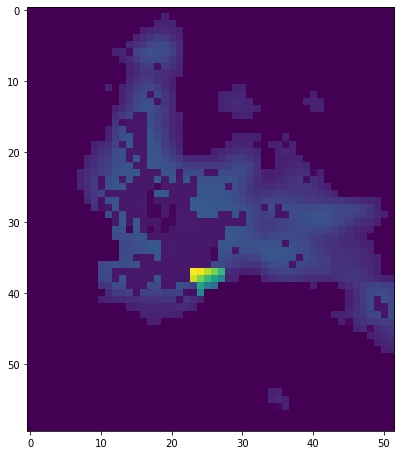

In [17]:
plt.imshow(seeds*100+W1)

In [18]:
variogram, mask ,locations = computeRegions(W1,coords[:],th = 0.25 ,atol=15,direction_delta = 2)


Coords  [ 6 17]
0.0 %


/Users/rodrigo/opt/anaconda3/envs/machineLearning/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/rodrigo/opt/anaconda3/envs/machineLearning/lib/python3.7/site-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

--
Coords  [11 11]
2.1739130434782608 %
--
Coords  [13 29]
4.3478260869565215 %
--
Coords  [13 40]
6.521739130434782 %
--
Coords  [14 16]
8.695652173913043 %
--
Coords  [18 17]
10.869565217391305 %
--
Coords  [19 14]
13.043478260869565 %
--
Coords  [19 17]
15.217391304347828 %
--
Coords  [20 36]
17.391304347826086 %
--
Coords  [21 15]
19.565217391304348 %
--
Coords  [22 17]
21.73913043478261 %
--
Coords  [23 15]
23.91304347826087 %
--
Coords  [24 18]
26.08695652173913 %
--
Coords  [24 20]
28.26086956521739 %
--
Coords  [24 22]
30.434782608695656 %
--
Coords  [26 18]
32.608695652173914 %
--
Coords  [27 12]
34.78260869565217 %
--
Coords  [27 16]
36.95652173913043 %
--
Coords  [28 19]
39.130434782608695 %
--
Coords  [28 34]
41.30434782608695 %
--
Coords  [28 36]
43.47826086956522 %
--
Coords  [29 13]
45.65217391304348 %
--
Coords  [29 24]
47.82608695652174 %
--
Coords  [29 41]
50.0 %
--
Coords  [30 13]
52.17391304347826 %
--
Coords  [30 15]
54.347826086956516 %
--
Coords  [30 22]
56.52173

TypeError: list indices must be integers or slices, not tuple

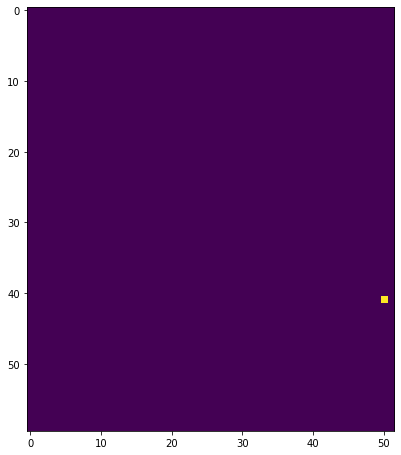

In [24]:
plt.imshow(W2)


zeros = np.zeros(W2.shape)


zeros[41,50]=1

plt.imshow(zeros)

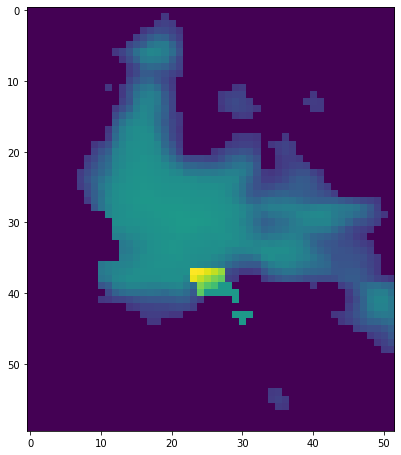

In [46]:
plt.imshow((np.max(nonsat)-1)*(importance==4)+nonsat)

In [ ]:
variogram, mask ,locations = computeRegions(nonsat,coords_nonsat[:],th = 10.0 ,atol=10,direction_delta = 2)

In [1547]:
len(variogram)

1

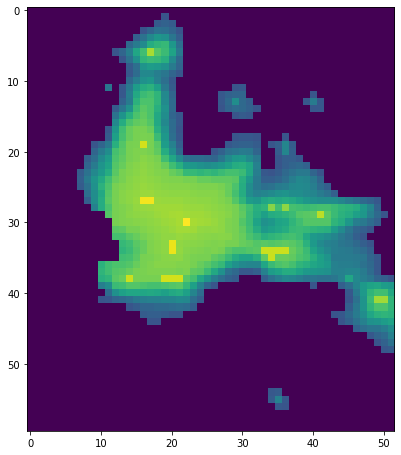

In [1544]:
plt.imshow(seeds_nonsat*10+nonsat)

In [1546]:
 plt.imshow(nonsat*50+mask[1]*np.max(W1)+locations[1]*10000)
    

IndexError: index 1 is out of bounds for axis 0 with size 1

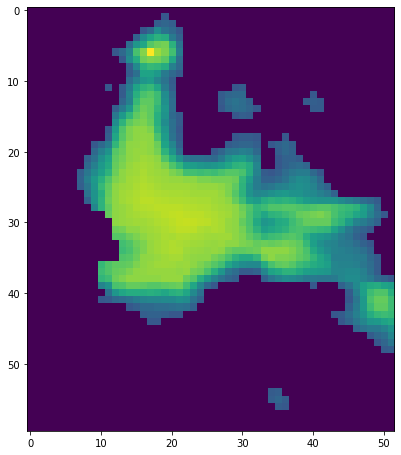

In [1545]:
for i in range(len(variogram)):
#    plt.imshow(mask[i]+locations[i])
    plt.imshow(nonsat*10+mask[i]*np.max(nonsat)+locations[i]*100)
    plt.show()

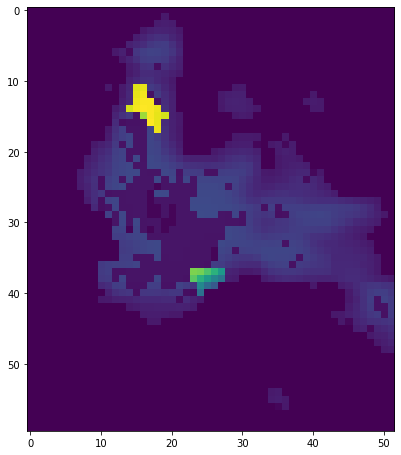

In [1389]:
plt.imshow(W1+mask[4]*np.max(W1))

Carga de Imágenes

In [785]:
#Region priorities of Jorge and Lamphar
#P = np.array(Image.open('example/inputs/prioridades'))

#calcular este valor automaticamente
nc = 5

# 0 máxima prioridad
# 4 mínima prioridad (antes espacio nan)
P = np.where(np.isnan(P),nc, P)-1 
P = P.max()-P


im1_gr = ps.filtro_fuerza_puntual(im1,h=3,e=4)

W1 = ps.f5(im1,P)
W2 = ps.f5(im1_gr,P)

In [1408]:



#plt.imshow(P)

P[0][0]


4.0

In [1410]:
th = 62
image = im1>=th
distance = ndi.distance_transform_edt(image)


nons = (im1>=th)*im1

nonsat = im1+(distance)


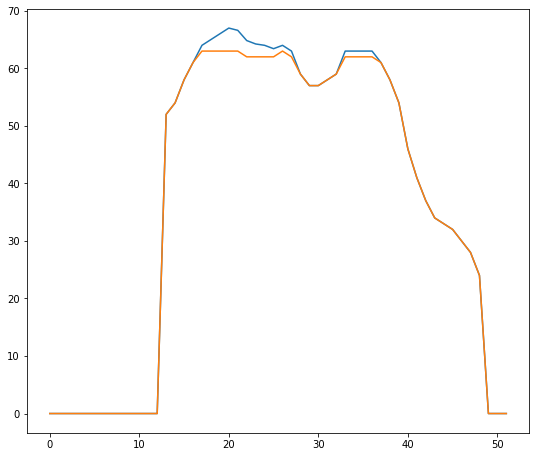

In [1411]:
plt.plot(nonsat[34][:])
plt.plot(im1[34][:])

Transformada de la distancia en la región saturada. Usamos esta en vez de la transformación que nos inventamos

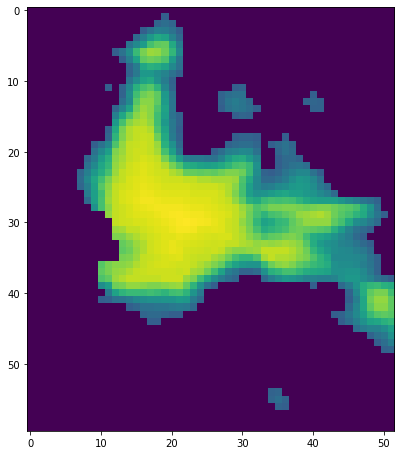

In [719]:
plt.imshow(nonsat)
plt.show()

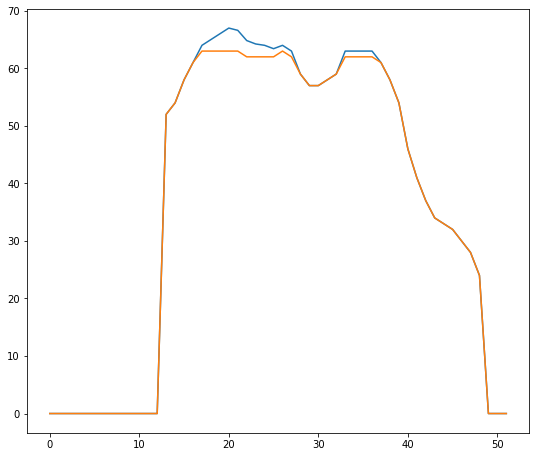

In [437]:
# Ejemplo Sección desaturada vs original saturada fila 34

plt.plot(nonsat[34,:])
plt.plot(im1[34,:])

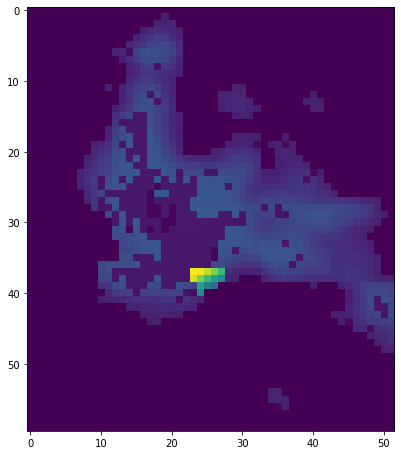

In [754]:




W1_nonsat = ps.f5(nonsat,P)

plt.imshow(W1_nonsat)

In [439]:
atol = 30
rs=30
th = 0.0025
setC = np.zeros(W1_nonsat.shape)
f = 1

In [440]:
#seeds = ps.getMax(nonsat,P)
seeds = ps.getMax(W1_nonsat)
coords = ps.get_coords(seeds)

In [9]:
plt.imshow(seeds*np.max(W1_nonsat)/5+W1_nonsat)

NameError: name 'W1_nonsat' is not defined

[ 6 17]


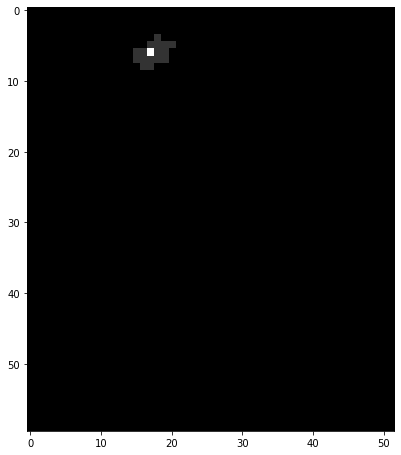

[11 11]


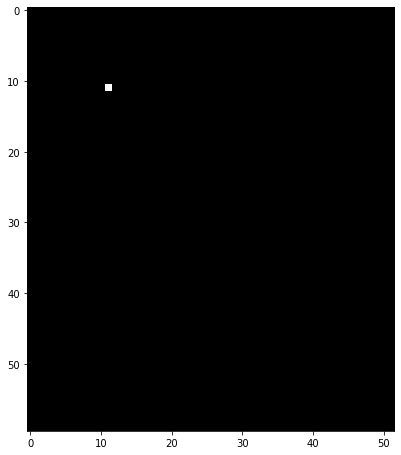

[13 29]


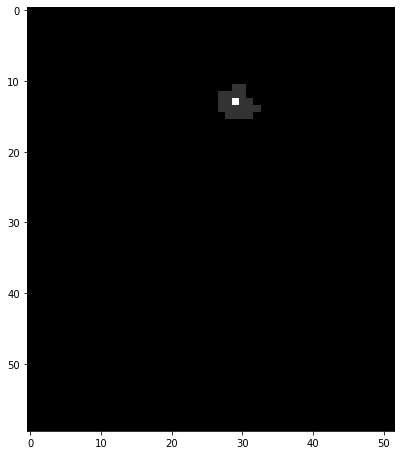

[13 40]


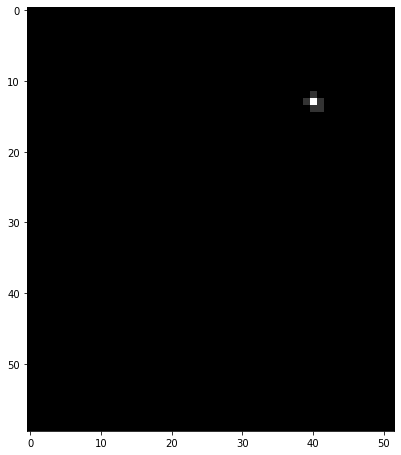

[14 16]


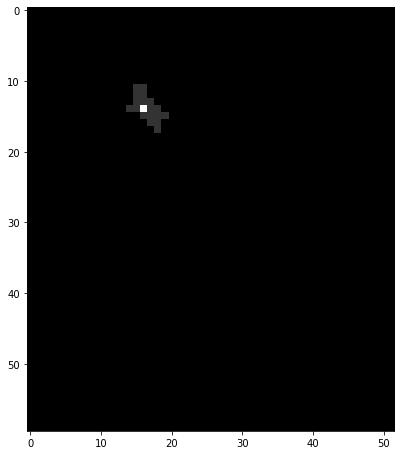

[18 17]


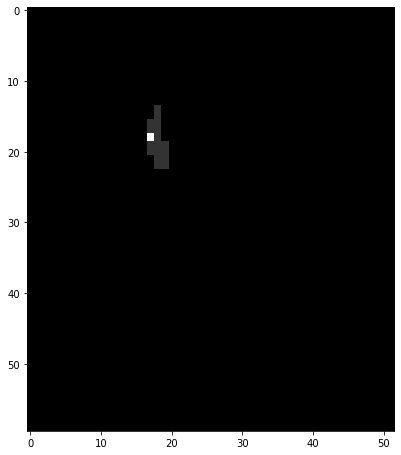

[19 14]


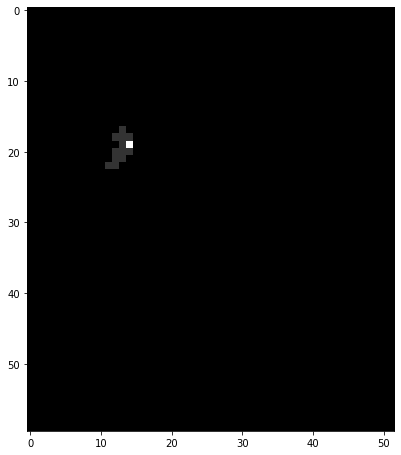

[19 17]


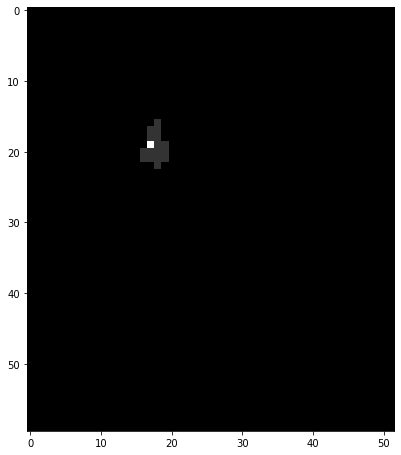

[20 36]


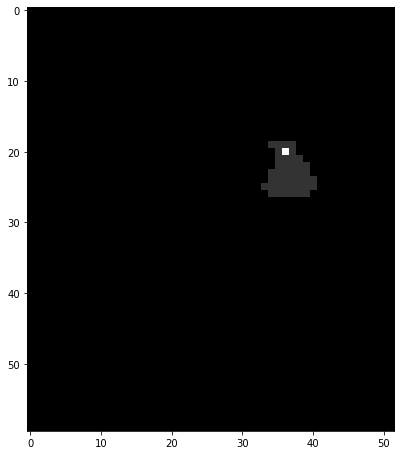

[21 15]


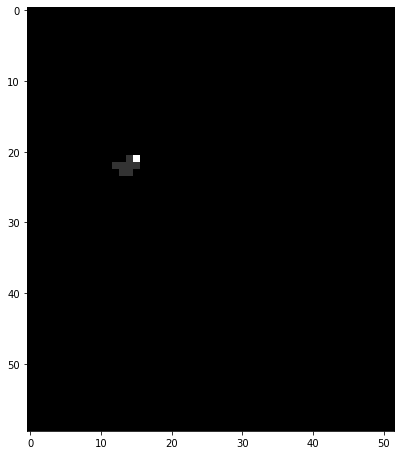

[22 17]


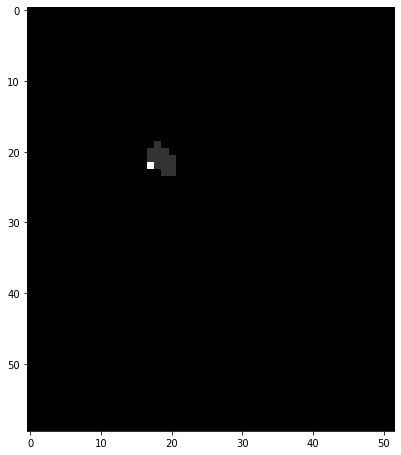

[23 15]


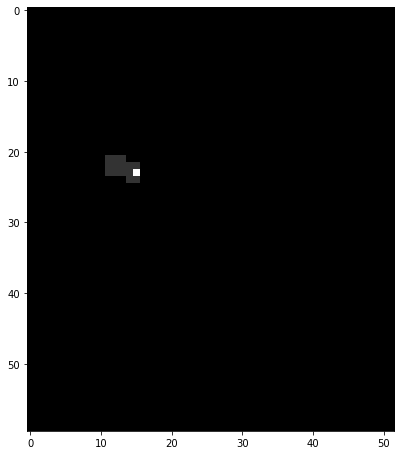

[24 18]


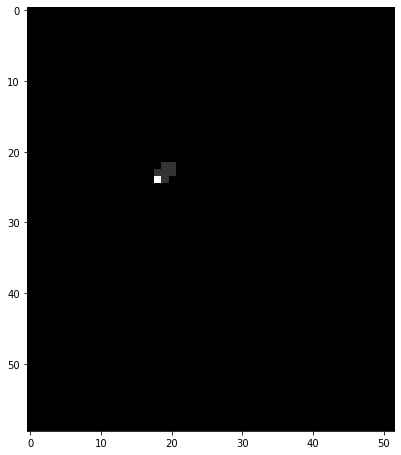

[24 20]


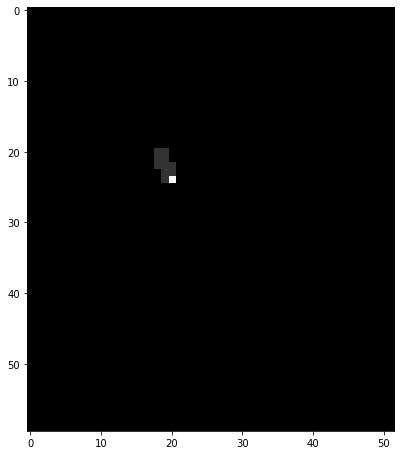

[24 22]


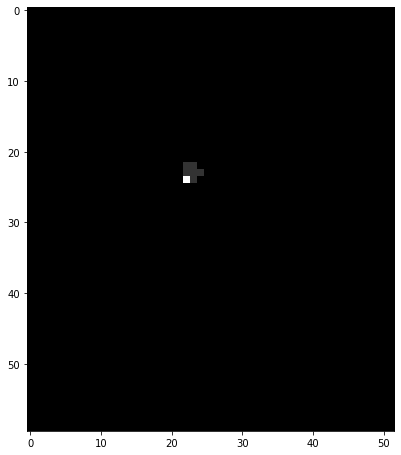

[26 18]


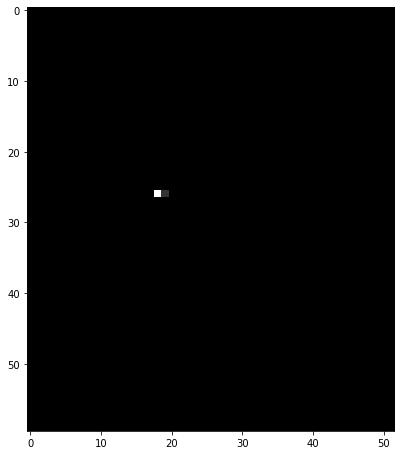

[27 12]


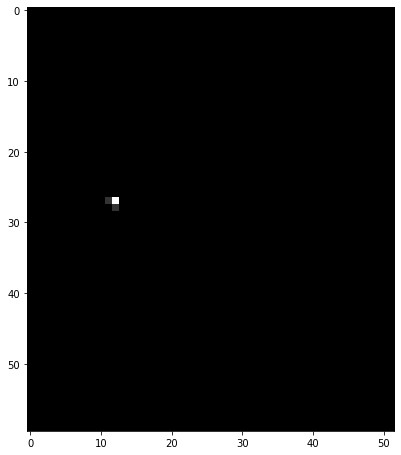

[27 16]


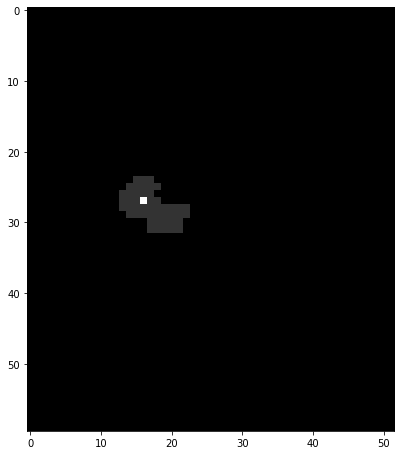

[28 19]


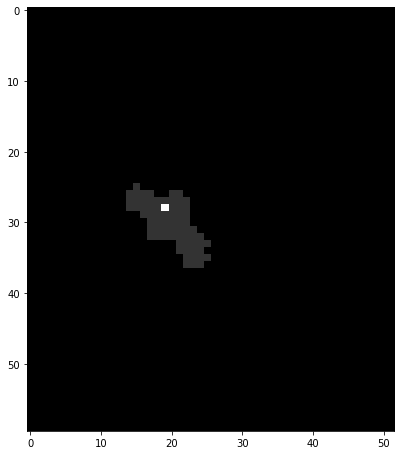

[28 34]


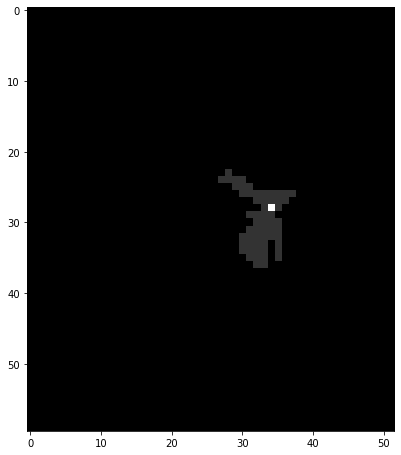

[28 36]


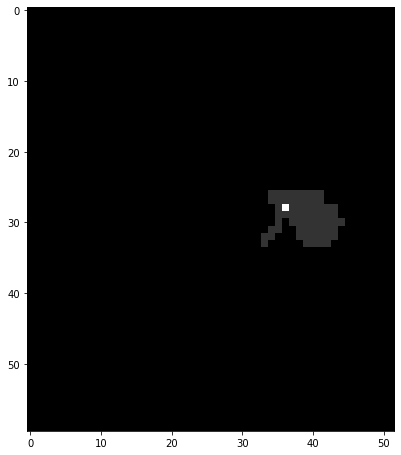

[29 13]


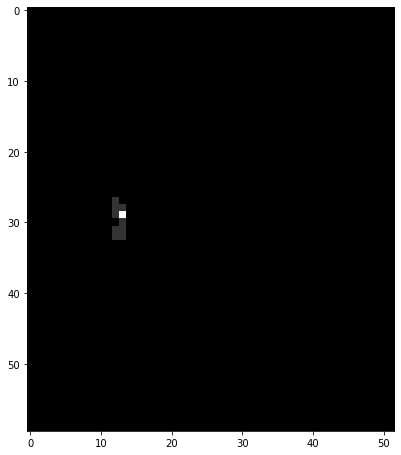

[29 24]


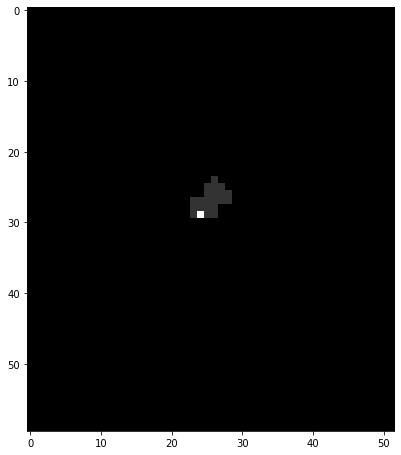

[29 41]


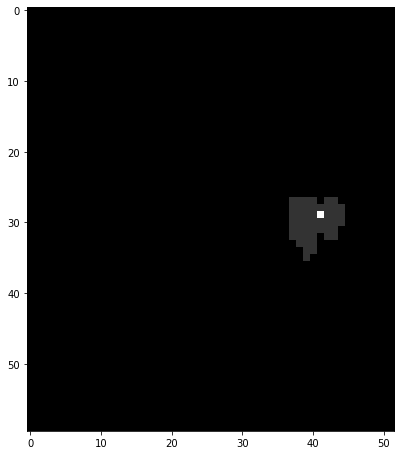

[30 13]


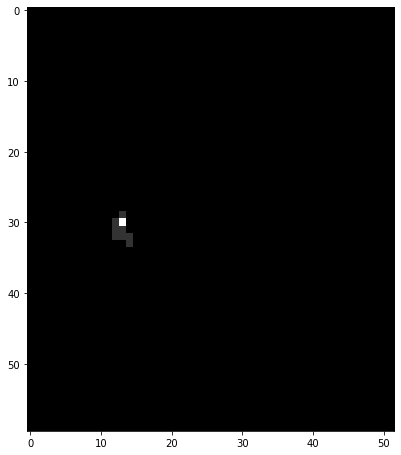

[30 15]


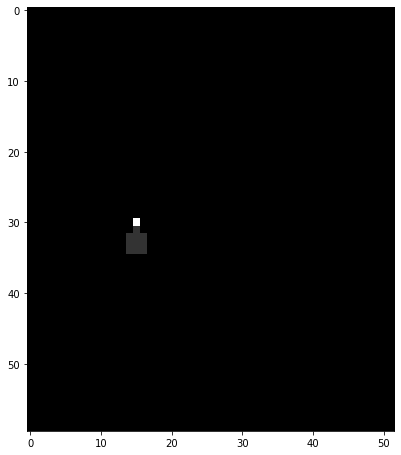

[30 22]


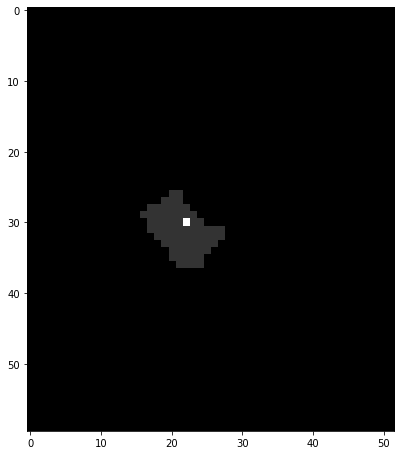

[32 28]


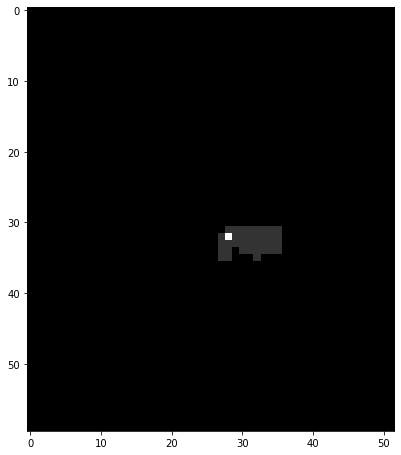

[33 18]


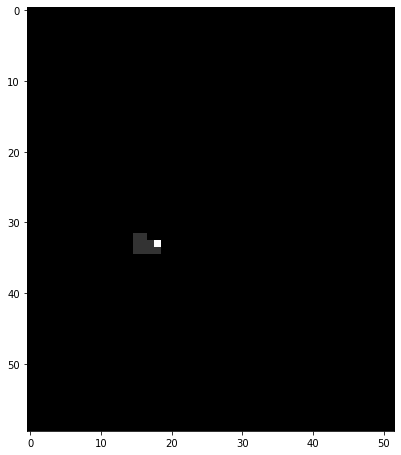

[33 20]


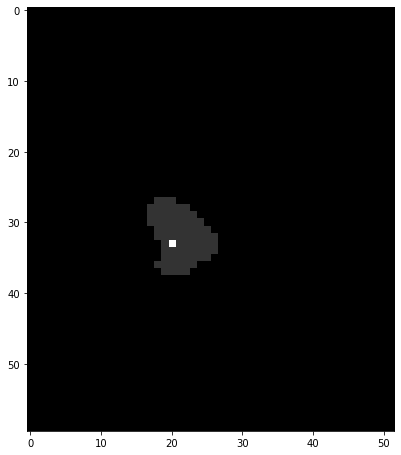

[34 18]


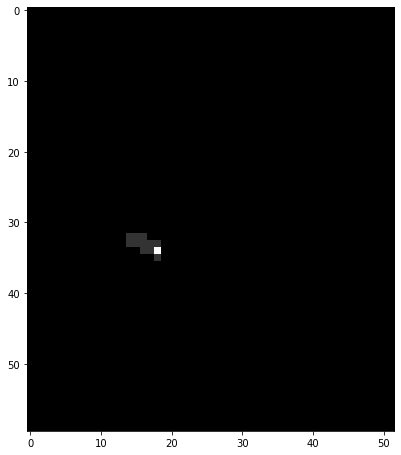

[34 20]


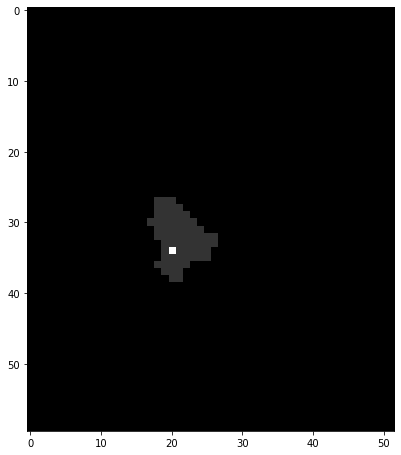

[34 33]


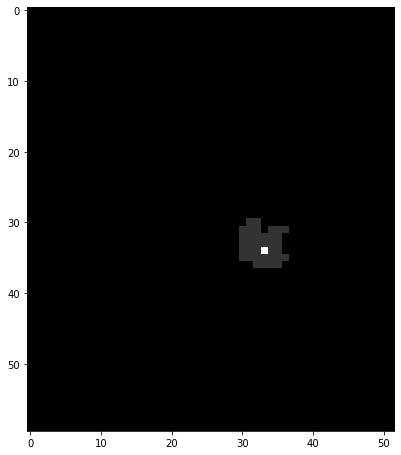

[34 34]


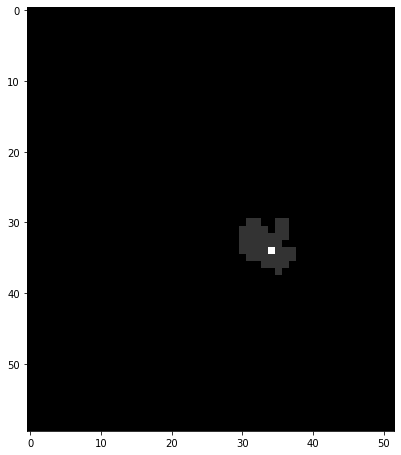

[34 35]


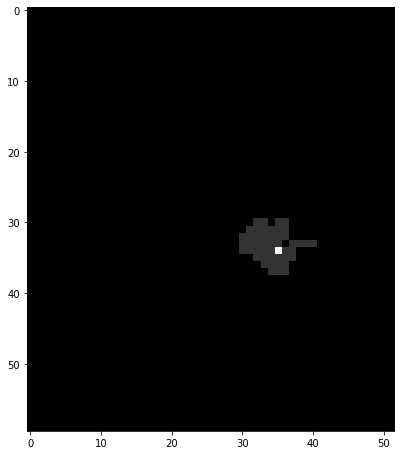

[34 36]


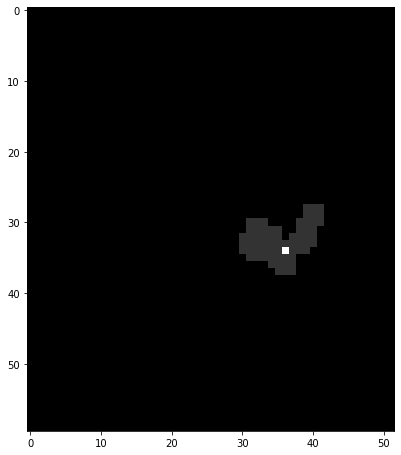

[35 34]


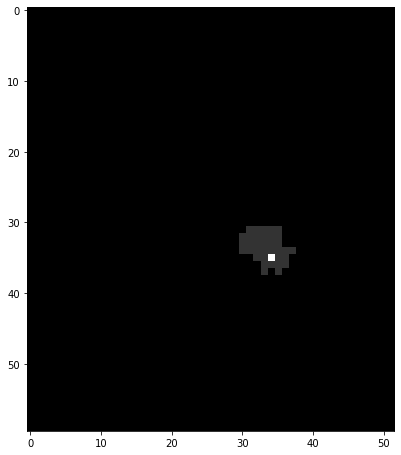

[36 12]


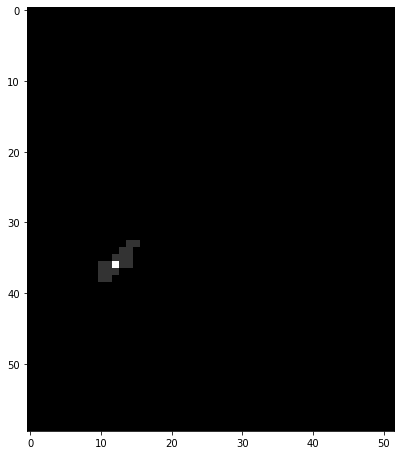

[36 15]


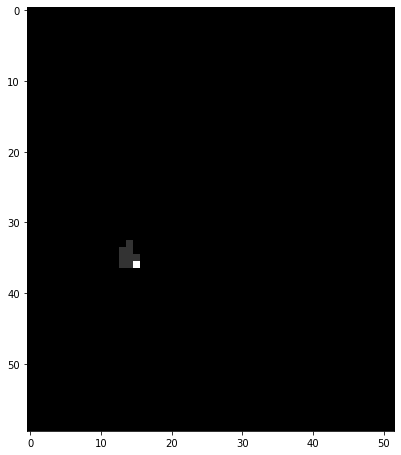

[37 23]


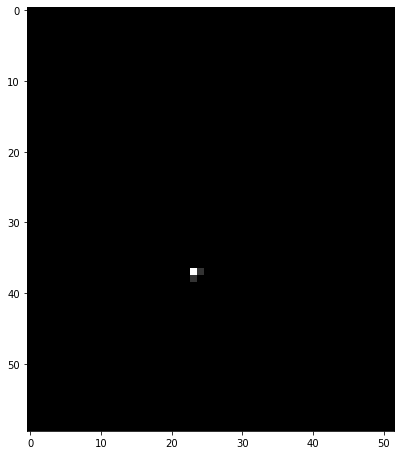

[38 13]


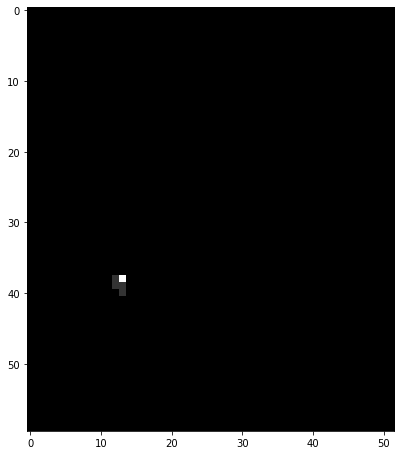

[38 18]


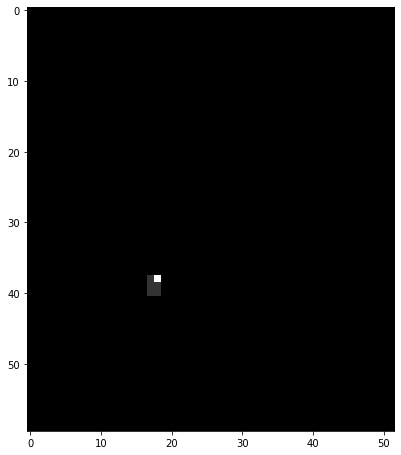

[38 45]


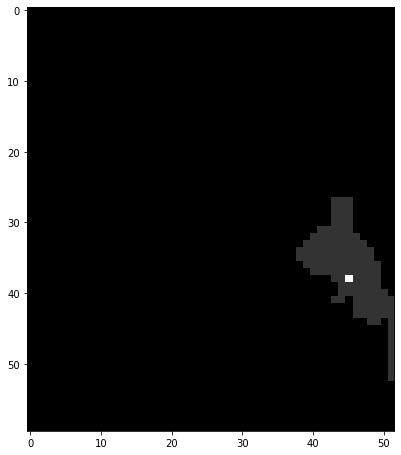

[39 21]


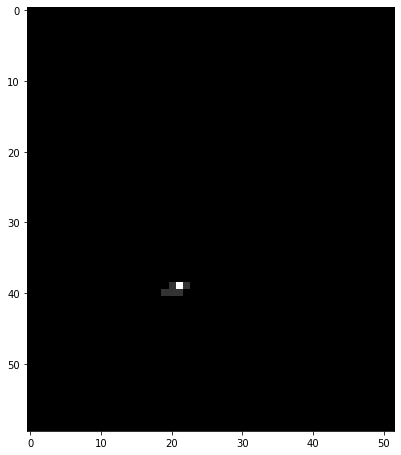

[41 50]


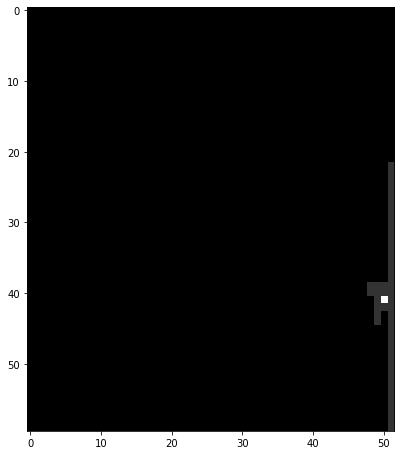

[55 35]


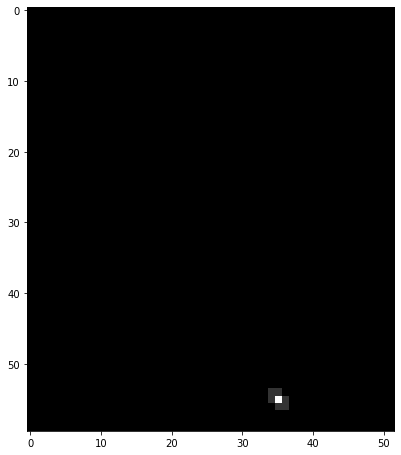

In [630]:
nonsat = W1_nonsat

footprint = disk(2)
atol = 30
rs=30
th = 0.003
setC = np.zeros(nonsat.shape)
f = 1
th = 100000
th = 589824

z = np.zeros((len(coords[1:]),nonsat.shape[0],nonsat.shape[1]))
mz = np.zeros((len(coords[1:]),nonsat.shape[0],nonsat.shape[1]))



for i,c in enumerate(coords[1:]):
    
    print(c)
    setC = np.zeros(nonsat.shape)
    dy = c[0]
    dx = c[1]

    for direction in range(0,359,2):
        
        setA = np.zeros(nonsat.shape)
        setB = np.zeros(nonsat.shape)

        gm1 = direction-atol
        gm2 = direction+atol
    
        m1 = np.tan(np.radians(gm1))
        m2 = np.tan(np.radians(gm2))

        for y in range(nonsat.shape[0]):
            for x in range(nonsat.shape[1]):
                
                #if angle is in right or left side
                if gm1<90 or gm1>90*3:
                    setA[y][x] = 1 if m1*(x-dx)+dy-y <0 else 0
                else:
                    setA[y][x] = 0 if m1*(x-dx)+dy-y <0 else 1

                if gm2<90 or gm2>90*3:
                    setB[y][x] = 0 if m2*(x-dx)+dy-y <0 else 1
                else:
                    setB[y][x] = 1 if m2*(x-dx)+dy-y < 0 else 0
                    

        mask = setA*setB
        p = np.array([dy,dx])
        sc = ps.makeSpatialScatter(p,mask,nonsat)
        accum = ps.variogram(sc)
        
 #       if not(direction<90 or direction>90*3):
            
        # detectamos hasta que indice se cumple el requerimiento de la varianza
        
        ##
        bs = accum <= th
        nf = np.where(bs==False)

        if len(nf[0])>0:

            bs[nf[0][0]:] = False
            radio = np.sum(bs)

        else:
    
            radio = len(bs)

        if direction==358:
         #   print("accum ",accum)
            inspect_p = p
            inspect_accum = accum
            inspect_mask = mask
            inspect_radio = radio
        
        for r in np.arange(0,radio,0.1):
 
            y = np.int(np.round(r*np.sin(np.radians(direction))))
            x = np.int(np.round(r*np.cos(np.radians(direction))))
            
            #we take care of the squared boundaries
            py = nonsat.shape[0]-1 if dy+y>=nonsat.shape[0] else dy+y
            px = nonsat.shape[1]-1 if dx+x>=nonsat.shape[1] else dx+x

            
     #       setC[py,px]=accum[int(r)]
            z[i][py,px] = accum[int(r)]
            mz[i][py,px]=1
 
#    z[i]=setC
    loc = np.zeros(nonsat.shape)
    loc[c[0]][c[1]]=1
    plt.imshow((mz[i]>0)+loc*4, cmap=plt.get_cmap("gray"))
    
    plt.show()
    
    


nonsat


In [629]:
(np.max(nonsat.flatten())/100*5)**2

589824.0

In [612]:
bs = inspect_accum <= th
nf = np.where(bs==False)

if len(nf[0])>0:
    
    bs[nf[0][0]:] = False
    r = np.sum(bs)

else:
    
    r = len(bs)
    
    
inspect_radio

1

In [597]:
for i,c in enumerate(coords):
    print(i,c)
    

0 [0 0]
1 [ 6 17]
2 [11 11]
3 [13 29]
4 [13 40]
5 [14 16]
6 [18 17]
7 [19 14]
8 [19 17]
9 [20 36]
10 [21 15]
11 [22 17]
12 [23 15]
13 [24 18]
14 [24 20]
15 [24 22]
16 [26 18]
17 [27 12]
18 [27 16]
19 [28 19]
20 [28 34]
21 [28 36]
22 [29 13]
23 [29 24]
24 [29 41]
25 [30 13]
26 [30 15]
27 [30 22]
28 [32 28]
29 [33 18]
30 [33 20]
31 [34 18]
32 [34 20]
33 [34 33]
34 [34 34]
35 [34 35]
36 [34 36]
37 [35 34]
38 [36 12]
39 [36 15]
40 [37 23]
41 [38 13]
42 [38 18]
43 [38 45]
44 [39 21]
45 [41 50]
46 [55 35]


In [443]:
sc = ps.makeSpatialScatter(inspect_p,inspect_mask,nonsat)

sc = np.sort(sc,axis=0)

vg=ps.variogram(sc)


vg



array([  32768.        ,  806229.33333333, 2016597.33333333,
       5079142.4       , 7129088.        , 7129088.        ,
       7129088.        , 7129088.        , 7129088.        ,
       7129088.        , 7129088.        , 7129088.        ,
       7129088.        , 7129088.        , 7129088.        ,
       7129088.        , 7129088.        , 7129088.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ])

In [430]:
h=3
ix = (sc[:,0]>(h-1))*(sc[:,0]<=h)

sc[ix]


array([[2.23606798e+00, 1.47865600e+06],
       [2.23606798e+00, 2.76889600e+06],
       [3.00000000e+00, 3.44473600e+06]])

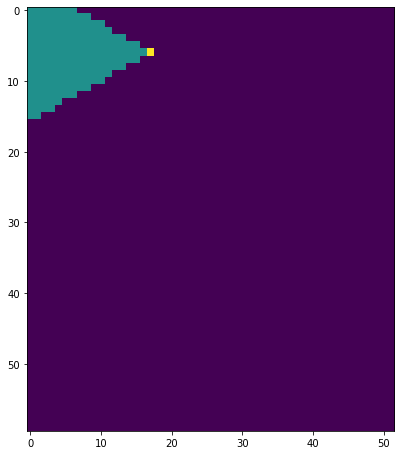

In [401]:
inspect_mask[c[0]][c[1]]=2
plt.imshow(inspect_mask)

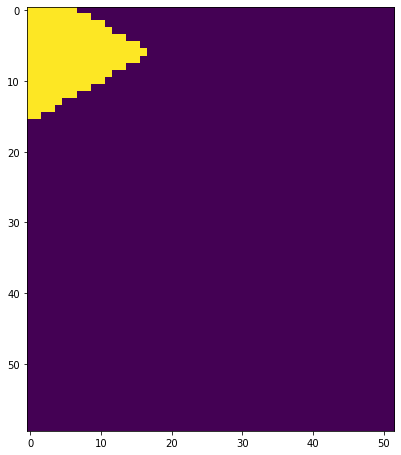

In [351]:
accum<th

plt.imshow(inspect_mask)



array([2.04800000e+03, 5.12000000e+04, 1.95242667e+05, 9.96010667e+05,
       3.16170240e+06, 7.12908800e+06, 7.12908800e+06, 7.12908800e+06,
       7.12908800e+06, 7.12908800e+06, 7.12908800e+06, 7.12908800e+06,
       6.80818215e+06, 6.36040533e+06, 6.72085333e+06, 6.77368123e+06,
       7.12908800e+06, 7.12908800e+06, 7.12908800e+06, 7.12908800e+06,
       7.12908800e+06, 7.12908800e+06, 7.12908800e+06, 6.62925553e+06,
       6.39988622e+06, 6.90143663e+06, 7.12908800e+06, 7.12908800e+06,
       7.12908800e+06])

In [411]:
(nonsat[c[0]][c[1]-1]-nonsat[c[0]][c[1]])**2


65536.0

In [152]:
from numpy import asarray
from numpy import savetxt


for i in range(0,len(z)):
    savetxt("variograms/data_variogram_{n}.csv".format(n=str(i)),z[i],delimiter=",")

savetxt("variograms/positions.csv".format(n=str(i)),coords[1:],delimiter=",")



In [154]:
from numpy import loadtxt

dict_data = loadtxt('variograms/'+'positions.csv',delimiter=",")


# extract the first array
#dict_data
# print the array
#print(data)


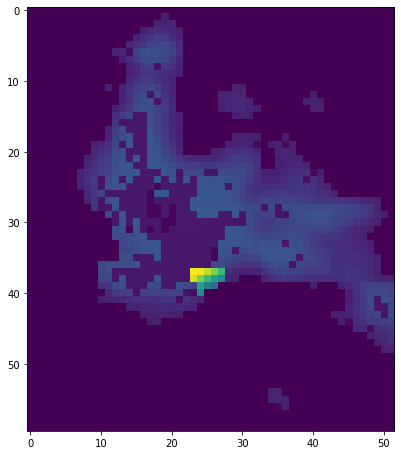

In [156]:
A = [nonsat,nonsat]
plt.imshow(A[1])


In [161]:
mask = np.zeros(im1.shape, dtype=bool)
mask[tuple(coords[1:].T)] = True

markers, _ = ndi.label(mask)
labels = watershed(-nonsat, markers, mask=im1)

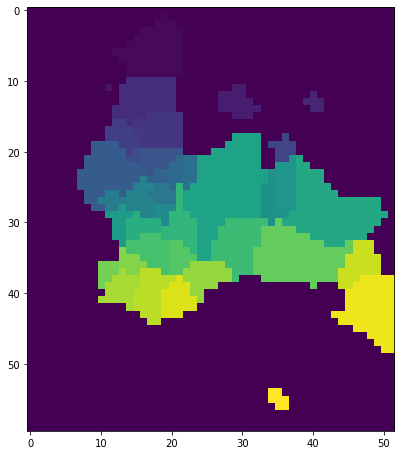

In [159]:
plt.imshow(labels)

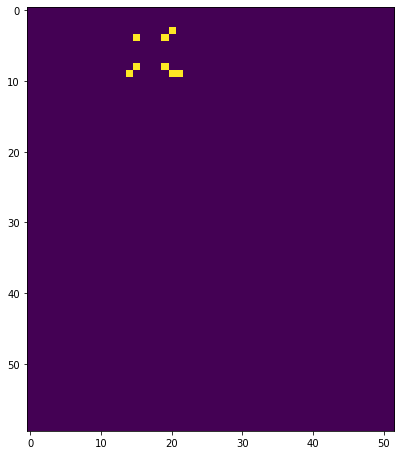

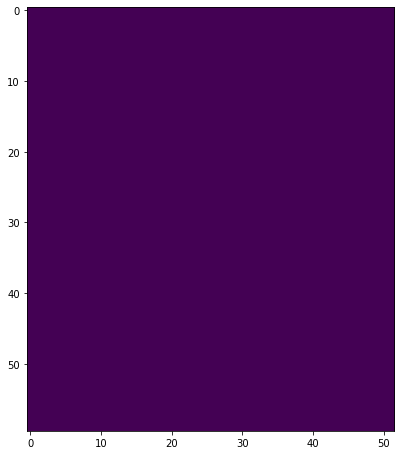

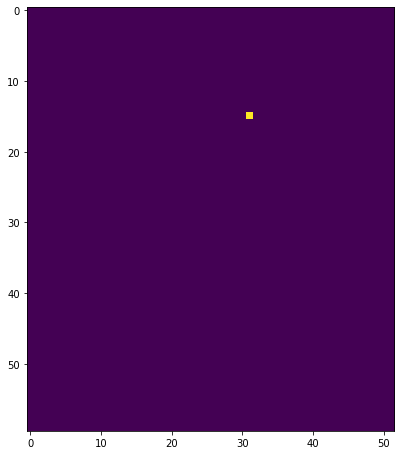

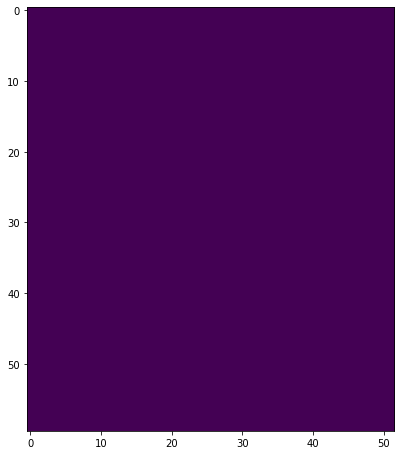

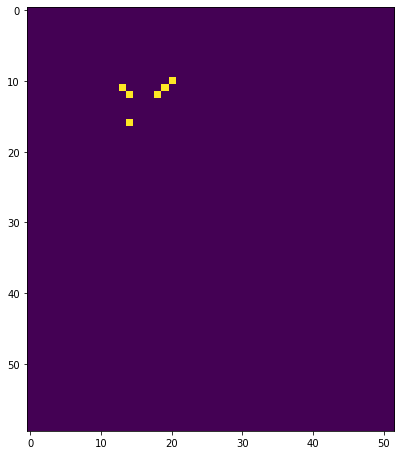

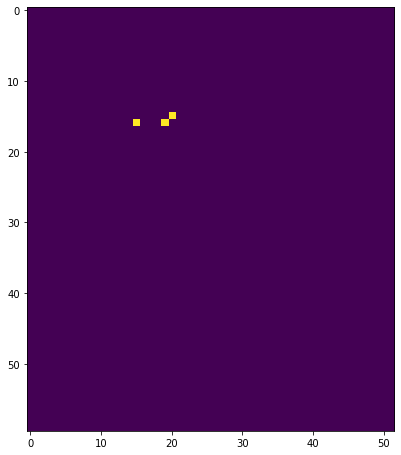

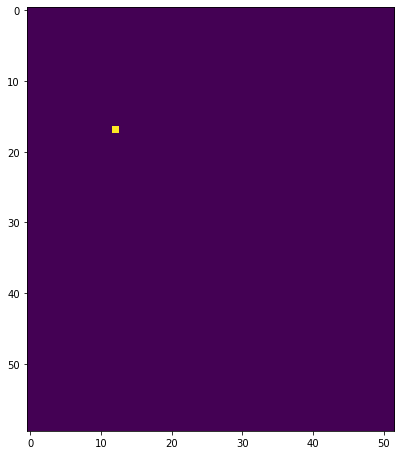

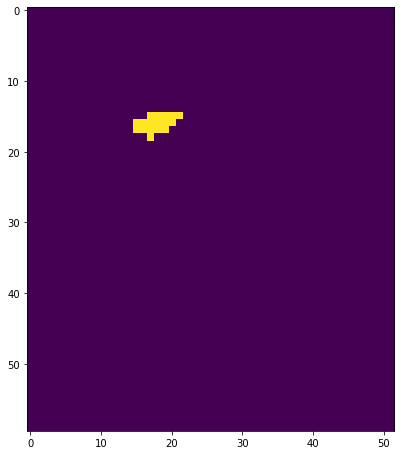

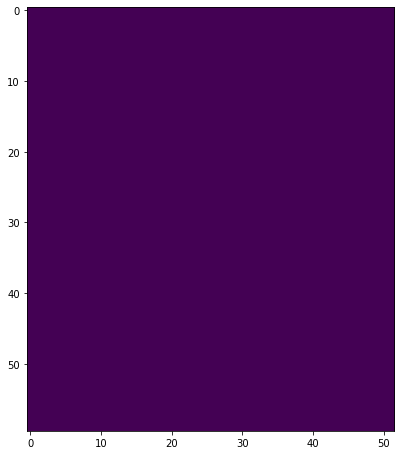

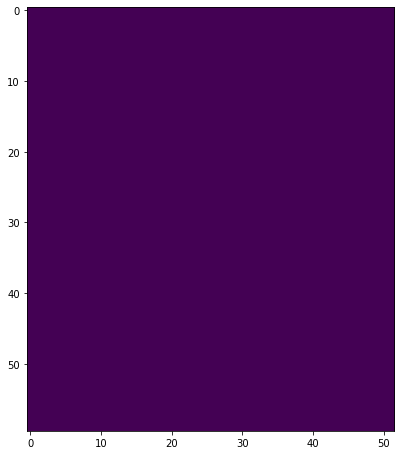

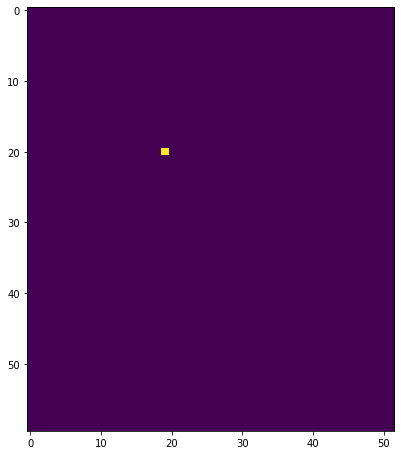

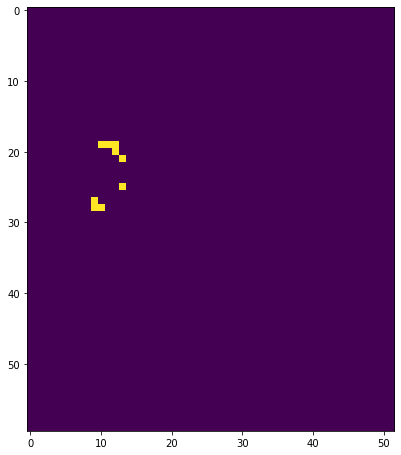

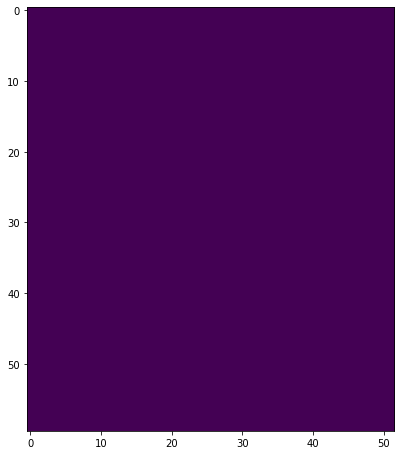

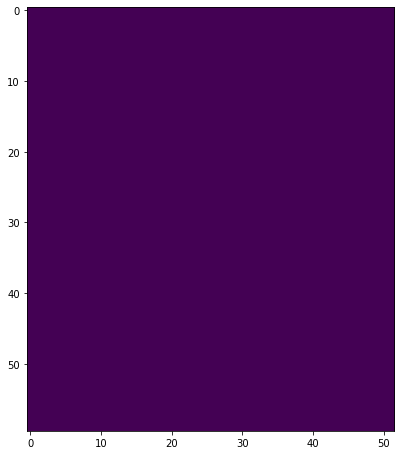

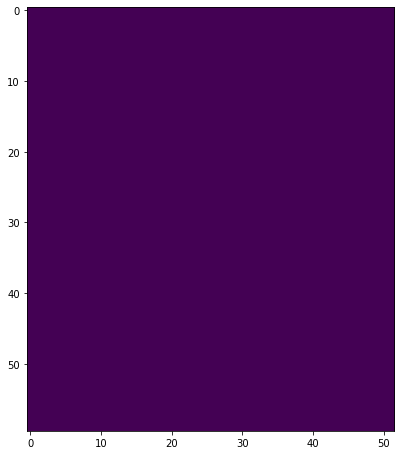

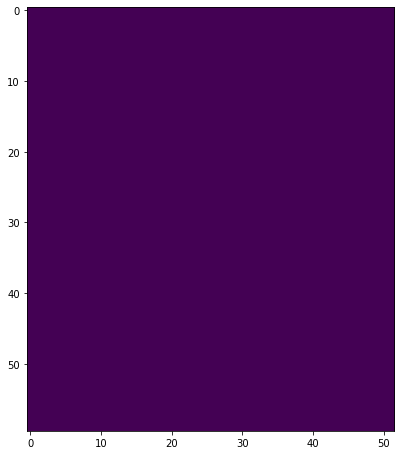

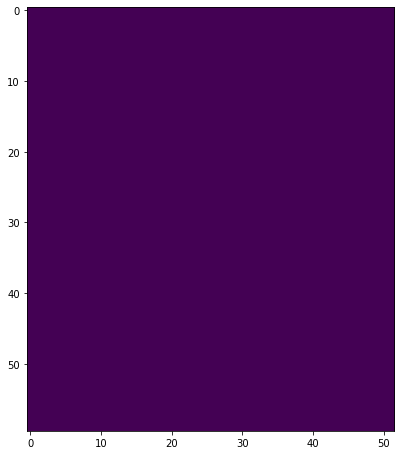

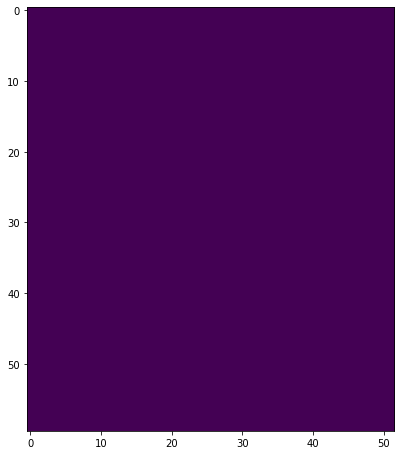

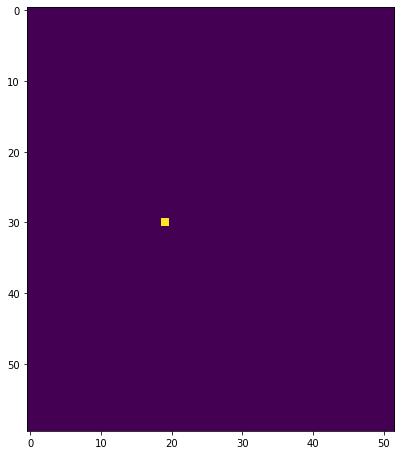

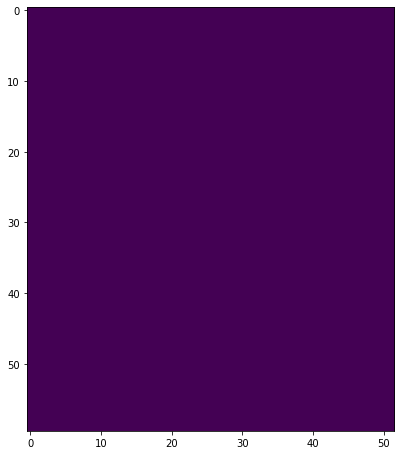

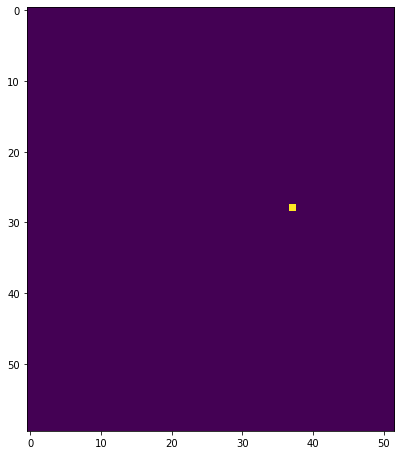

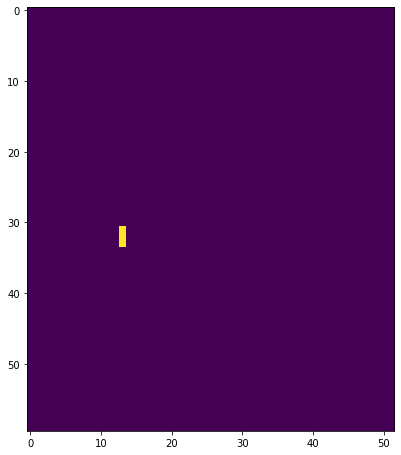

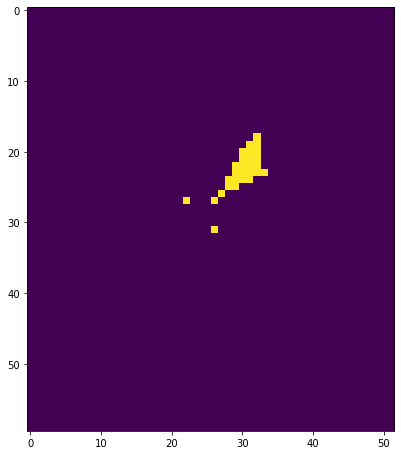

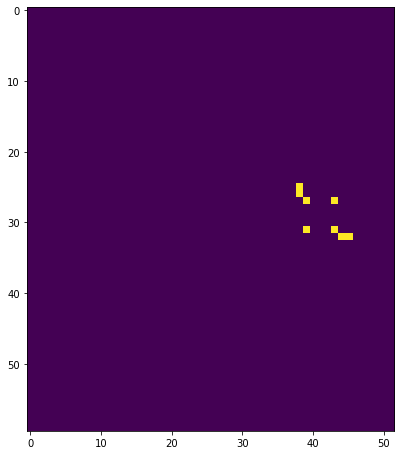

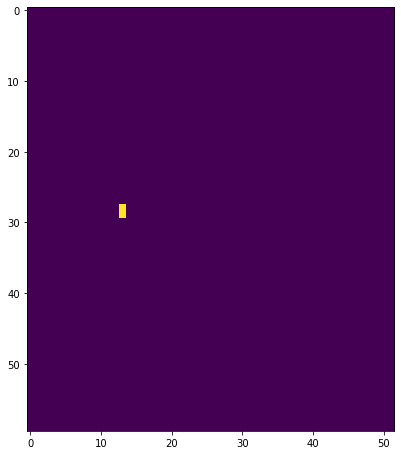

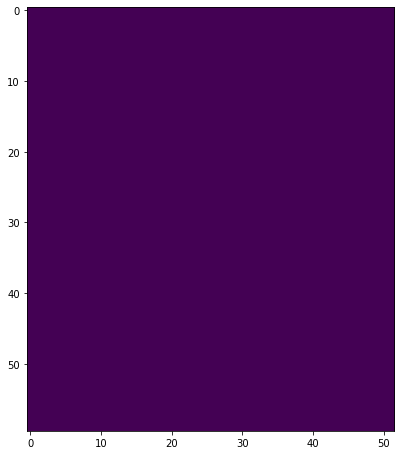

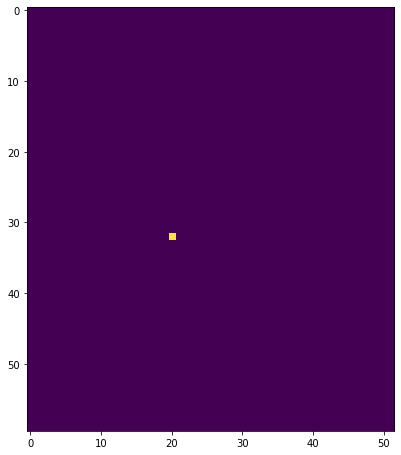

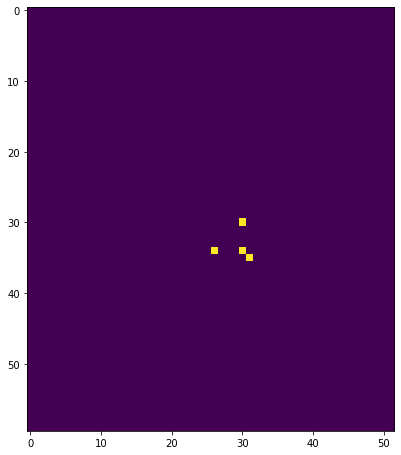

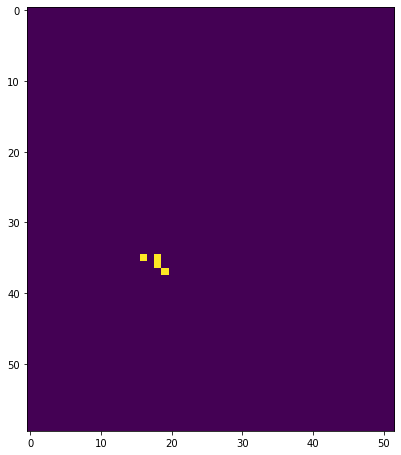

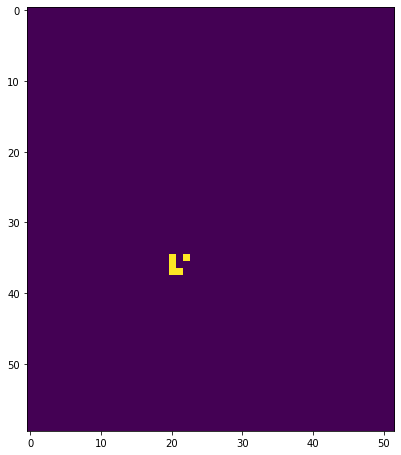

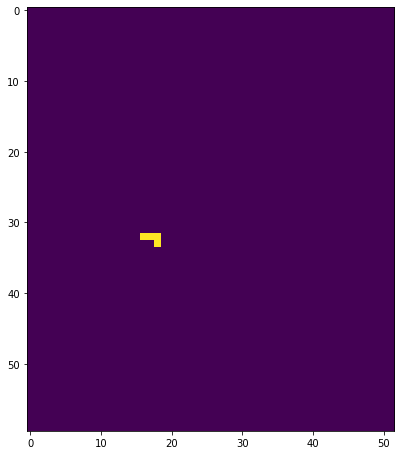

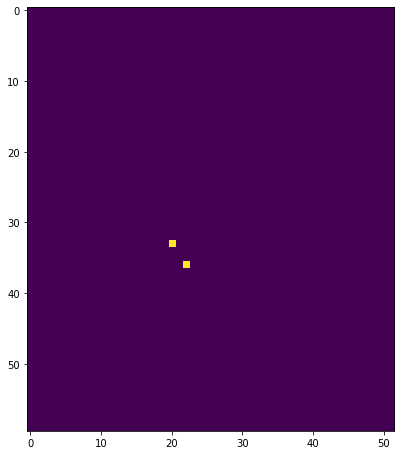

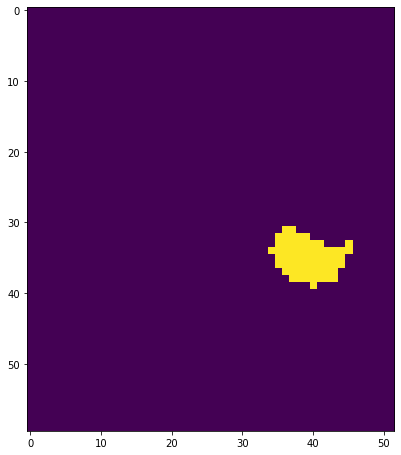

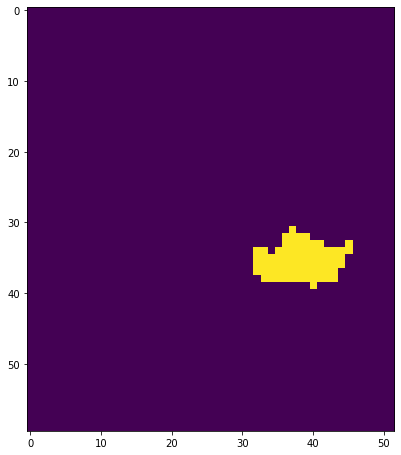

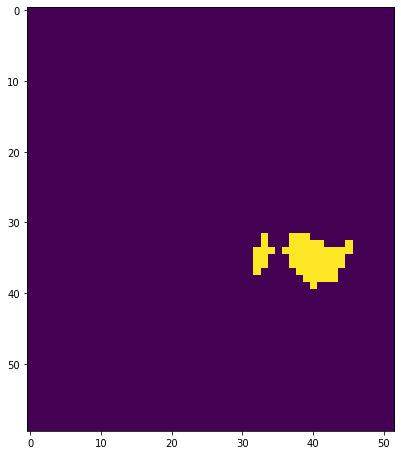

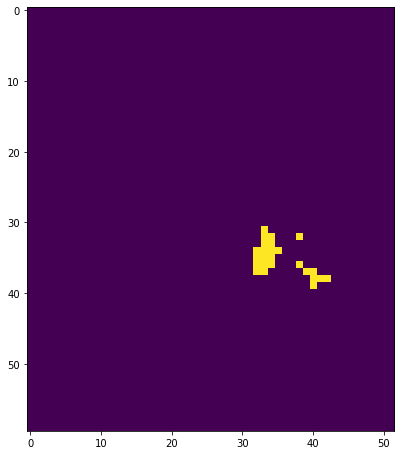

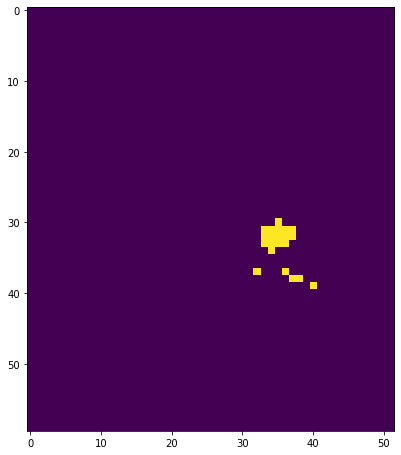

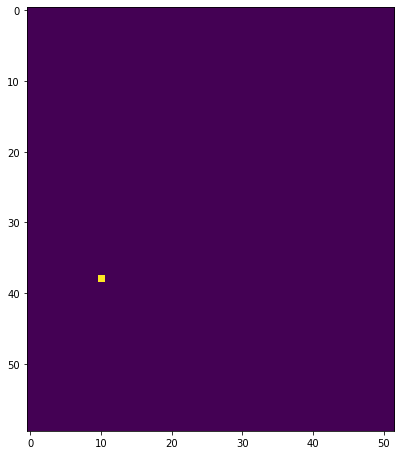

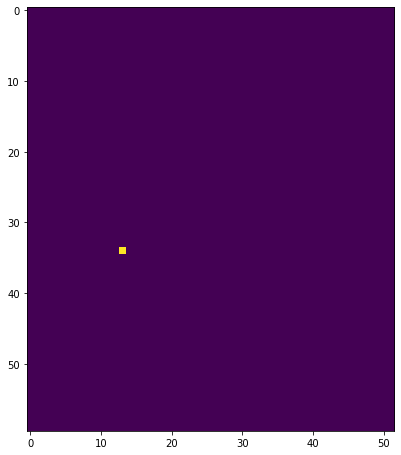

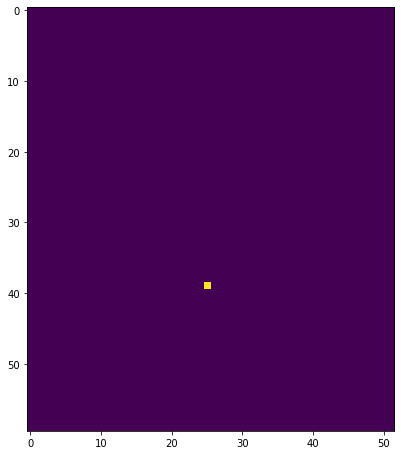

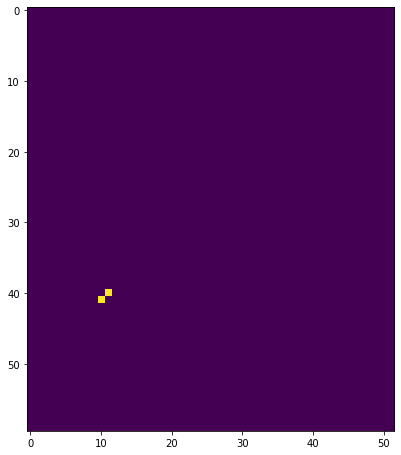

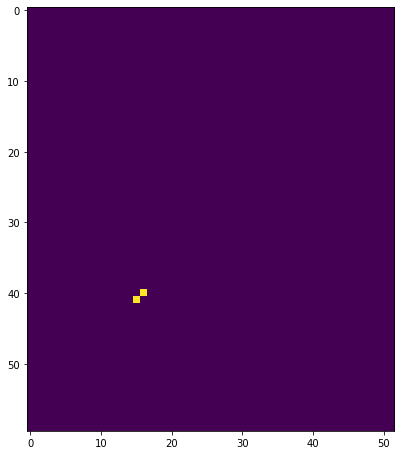

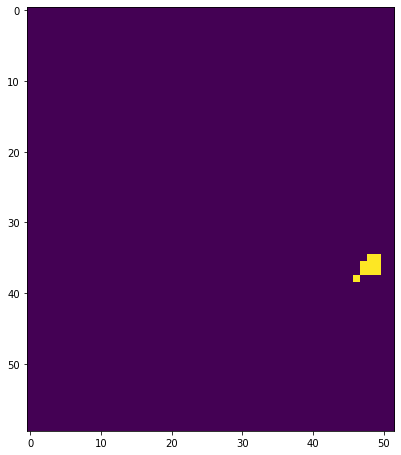

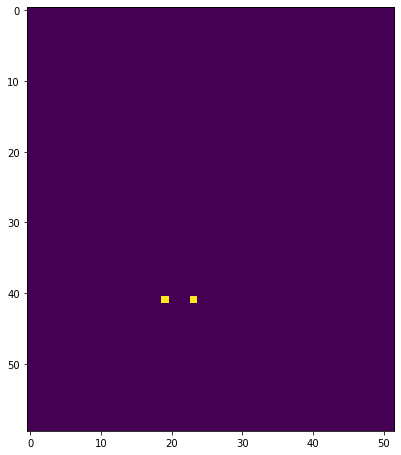

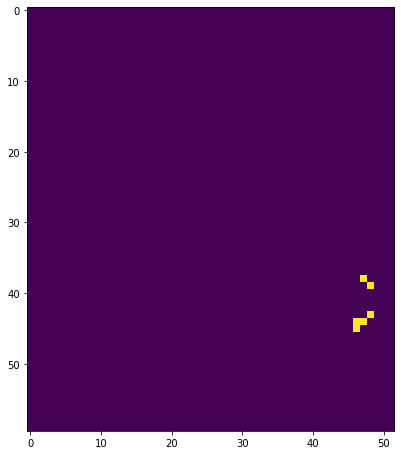

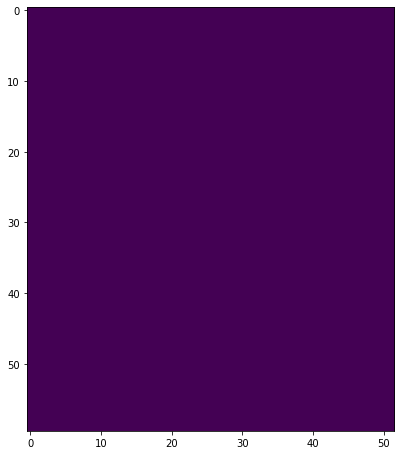

In [321]:
c = coords[1:]



def r(i,labels=labels, c = c):
    r = labels==labels[c[i][0],c[i][1]]
    return r


for i in range(len(z)):


    loc = np.zeros(z[0].shape)
    loc[c[i][0]][c[i][1]]=1
    plt.imshow(r(i)*(z[i]<1))
    plt.show()




## 

In [162]:
zws = np.zeros(( len(coords[1:]),labels.shape[0],labels.shape[1])) 

for i, c in enumerate(coords[1:]):
    zws[i] = labels==labels[c[0],c[1]]

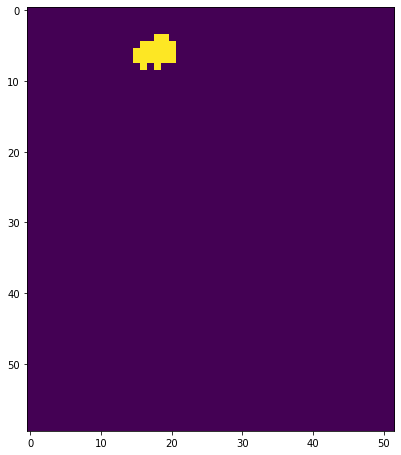

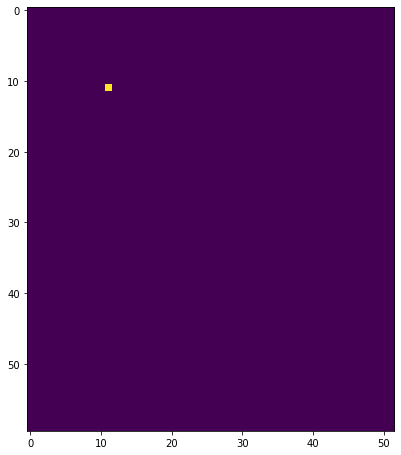

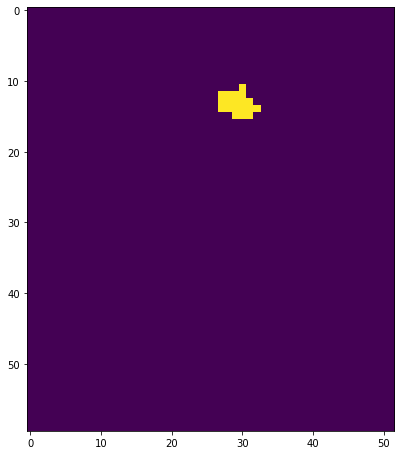

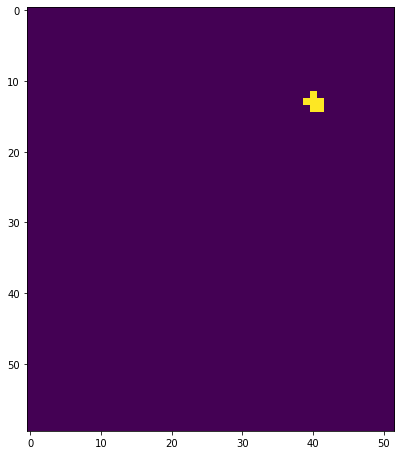

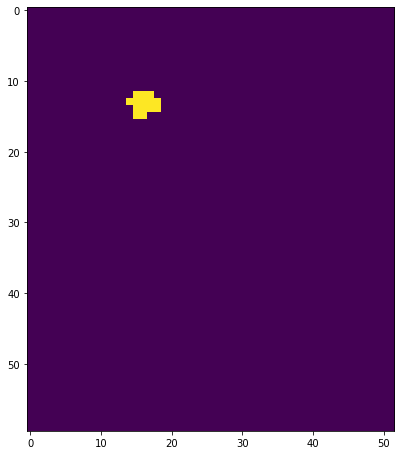

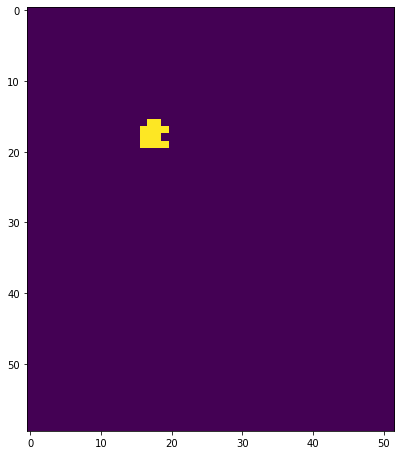

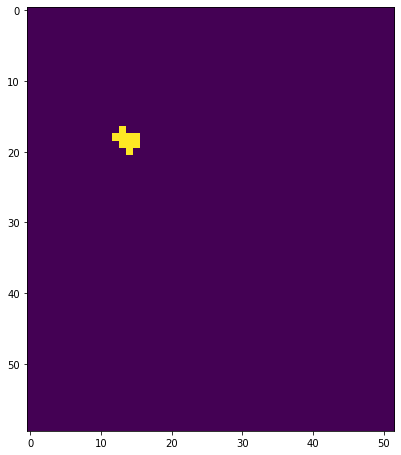

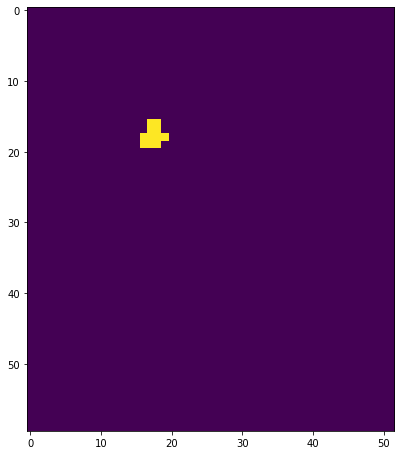

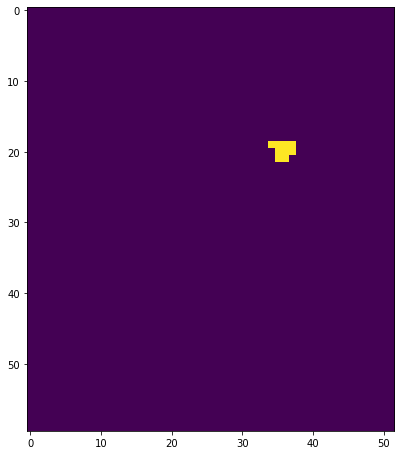

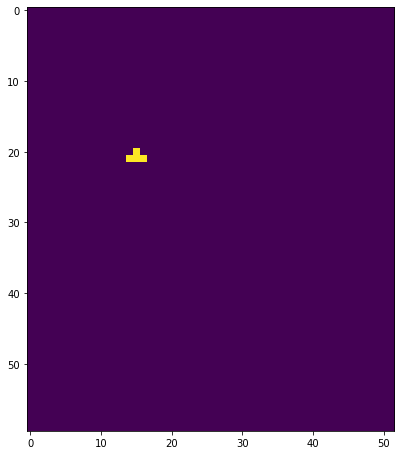

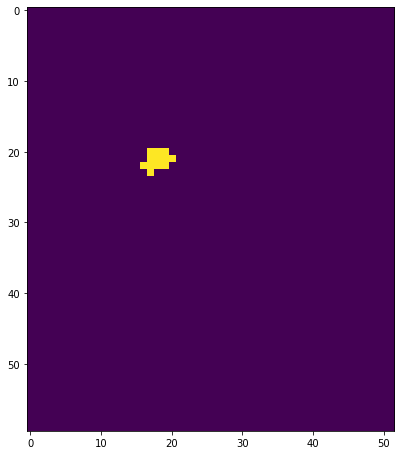

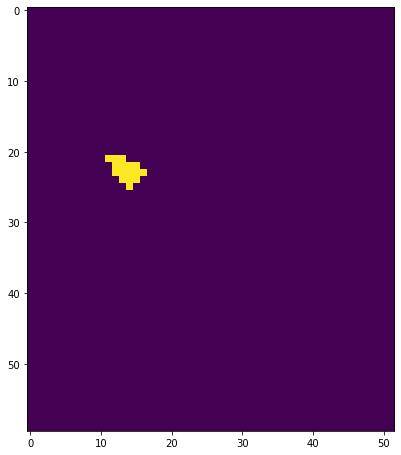

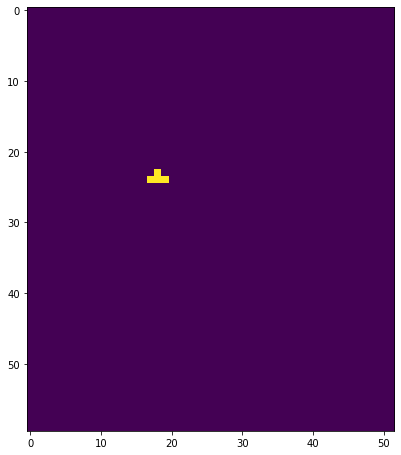

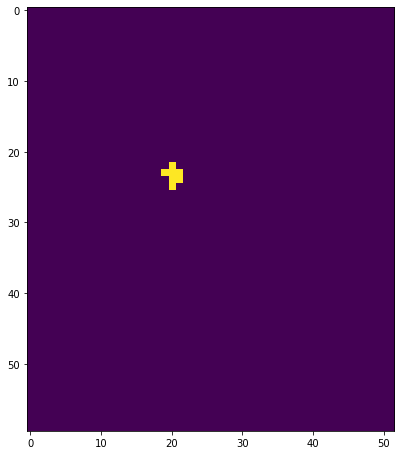

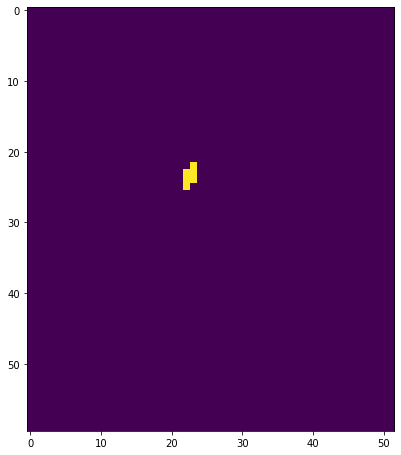

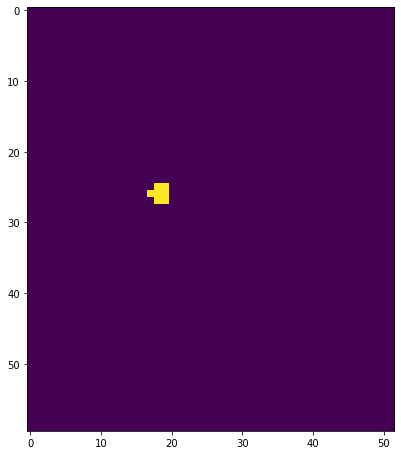

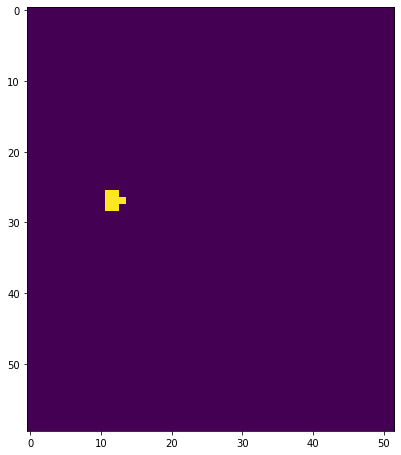

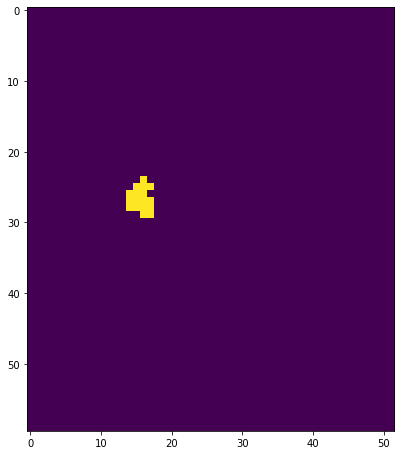

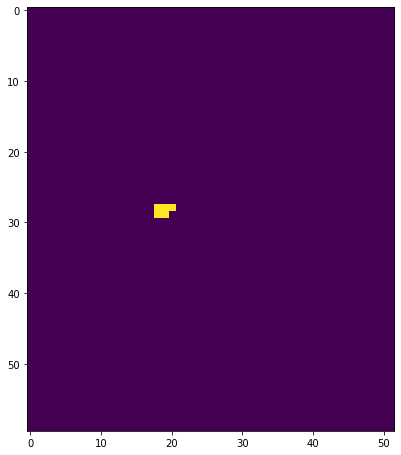

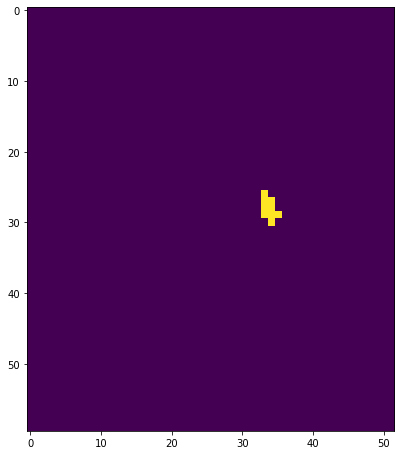

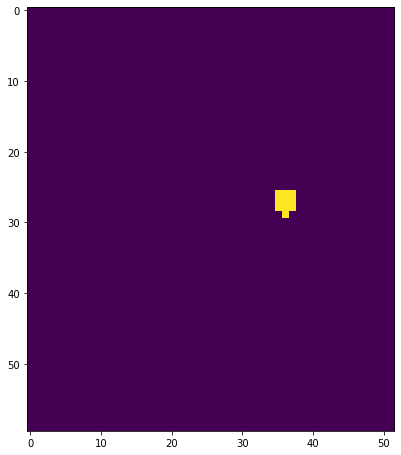

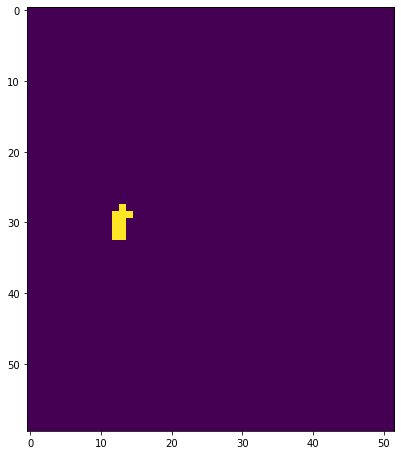

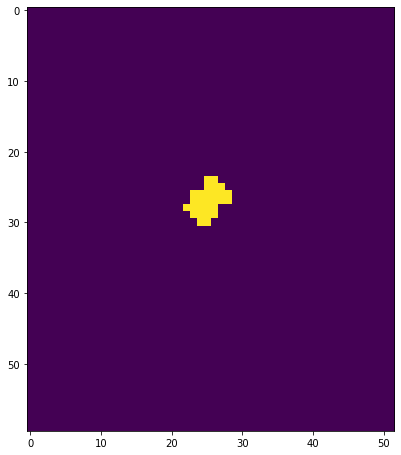

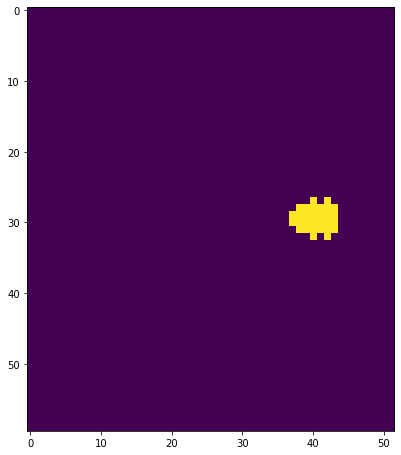

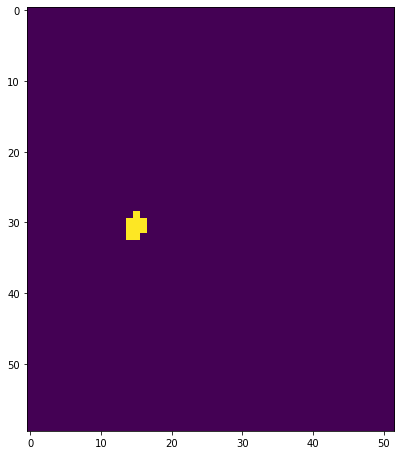

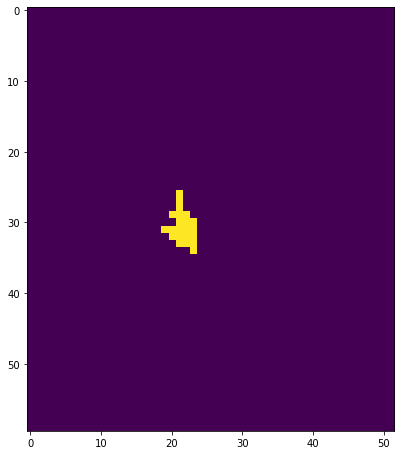

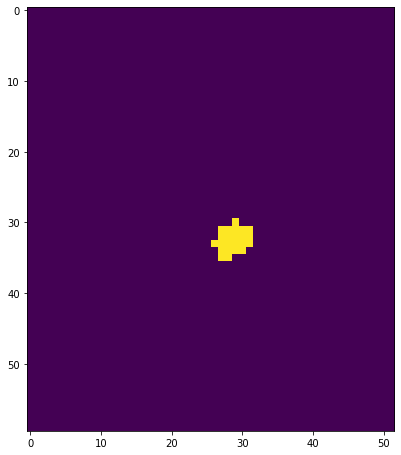

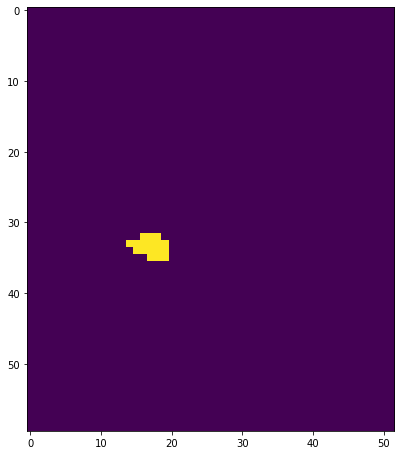

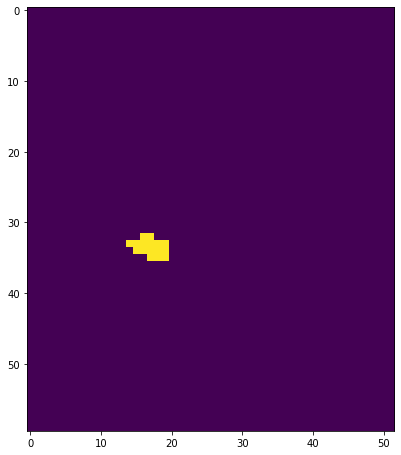

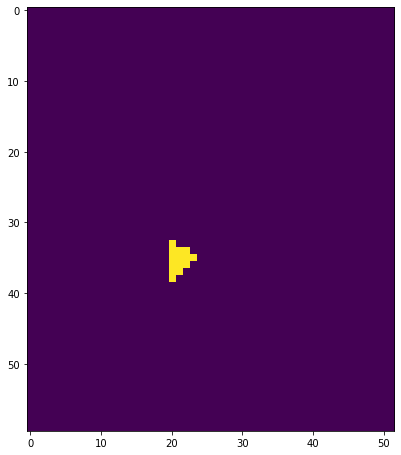

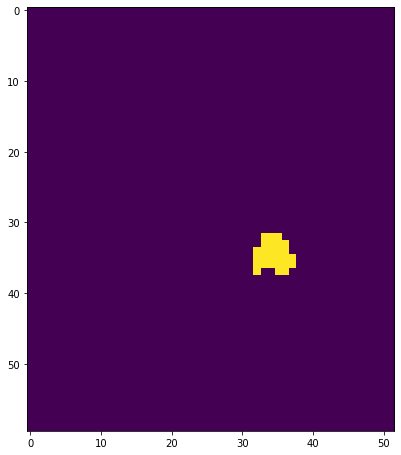

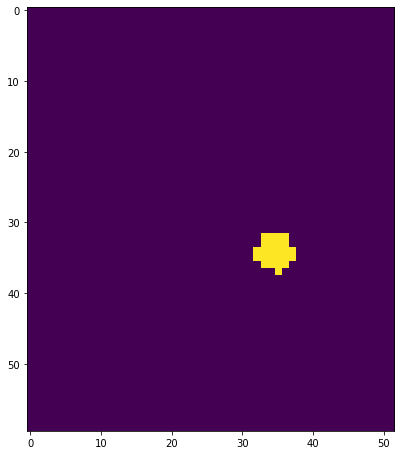

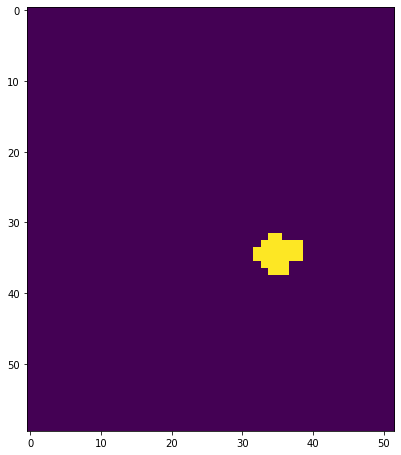

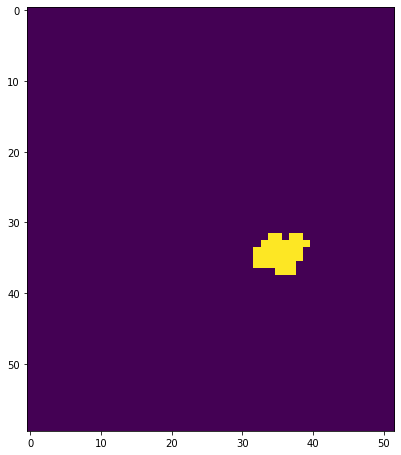

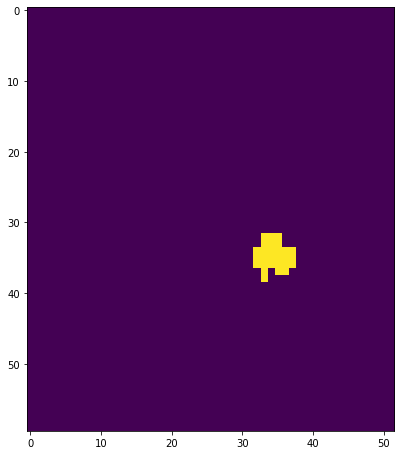

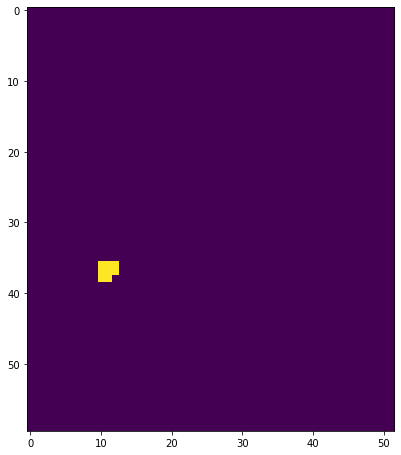

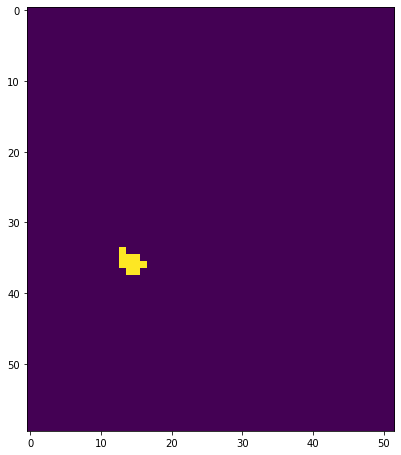

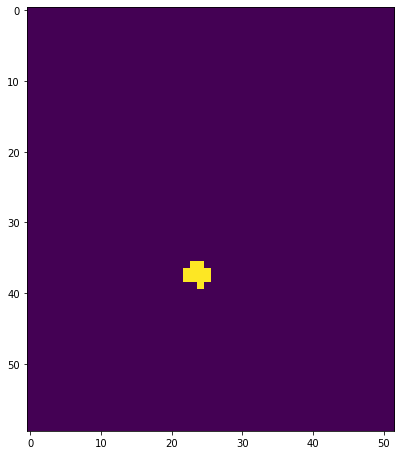

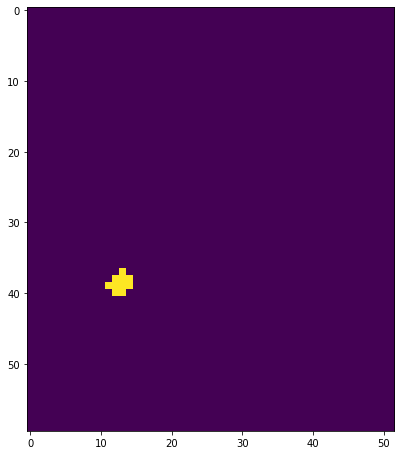

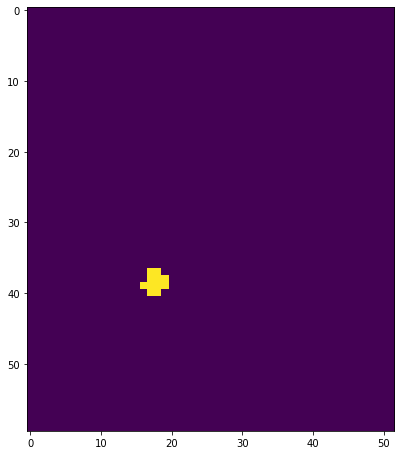

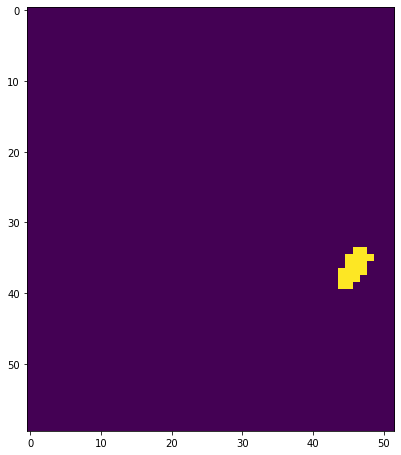

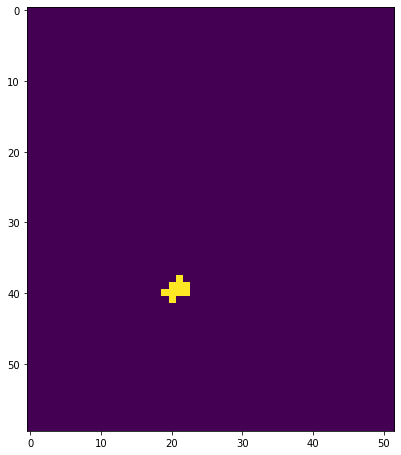

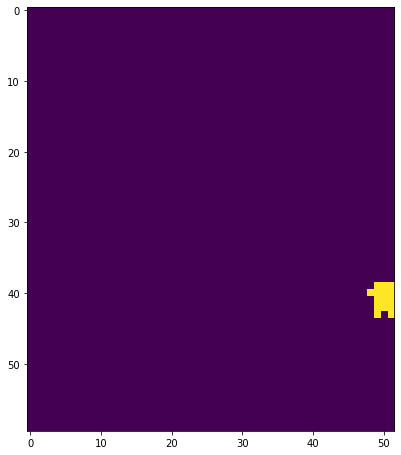

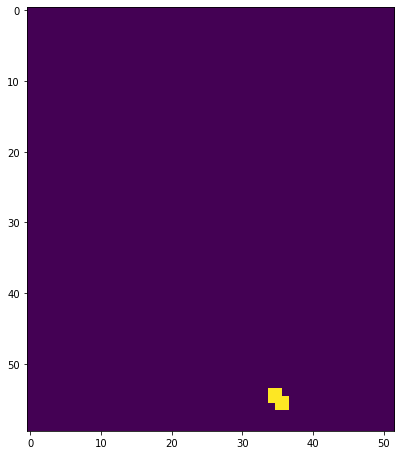

In [21]:
allregions = np.zeros((labels.shape[0],labels.shape[1])) 

for i in range(len(z)):
    
    r = (zws[i]*(z[i]>0))*(i+1)
    plt.imshow(r)
    allregions +=r
    plt.show()

In [164]:
def get_region(s,labels,c):
    return labels==labels[c[0],c[1]]

get_region()
    

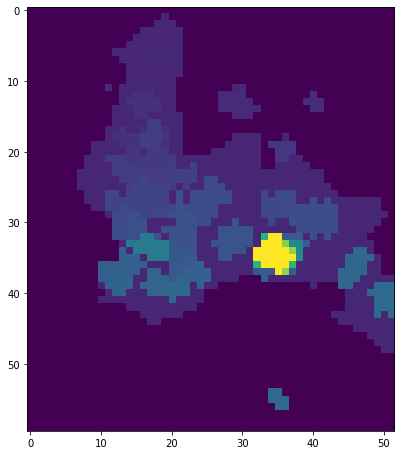

In [22]:
plt.imshow(allregions+(nonsat>0)*20)

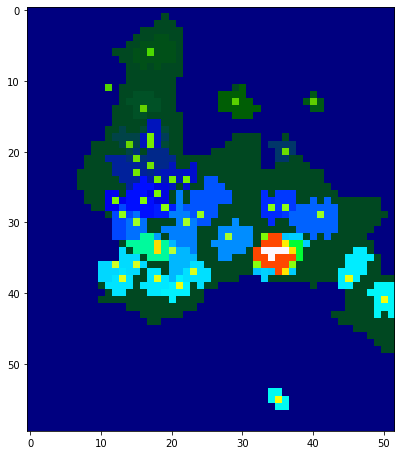

In [23]:
plt.imshow((allregions)+(nonsat>0)*10+seeds*10, cmap=plt.get_cmap("gist_ncar"))

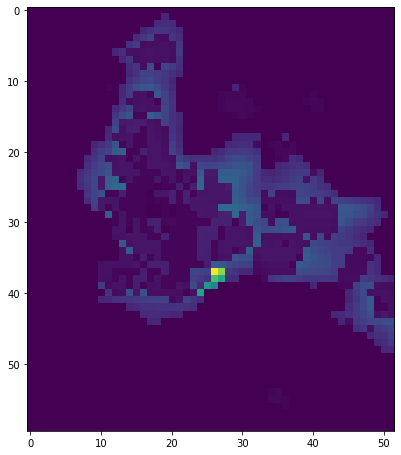

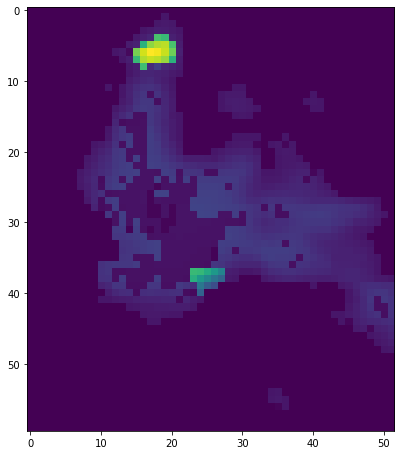

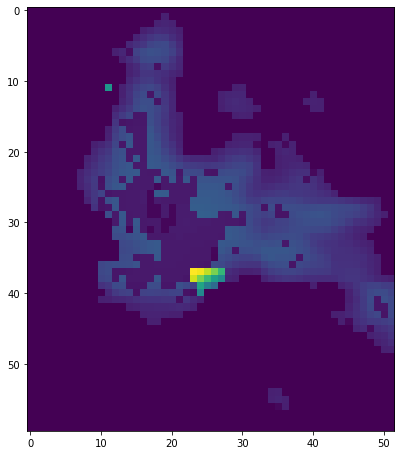

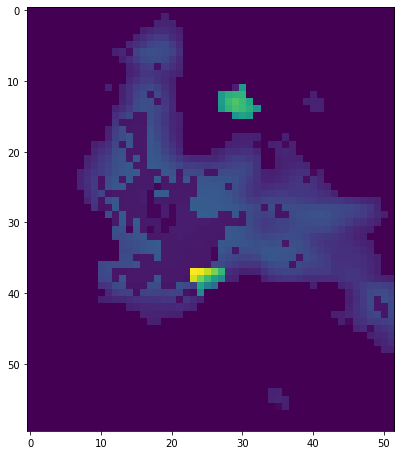

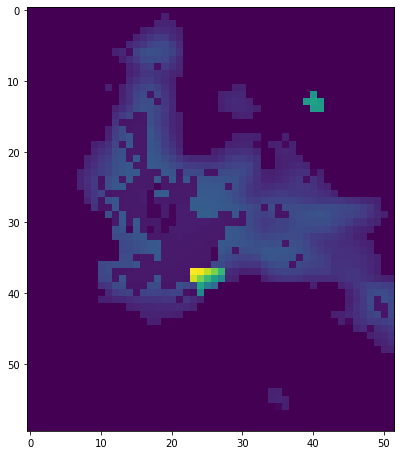

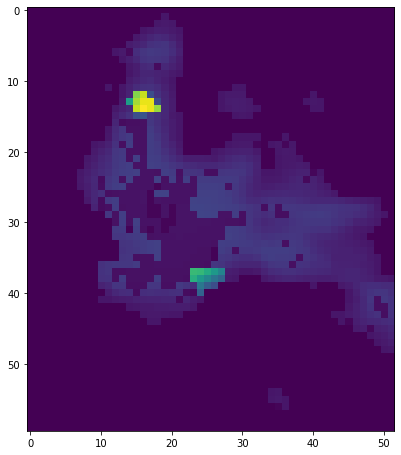

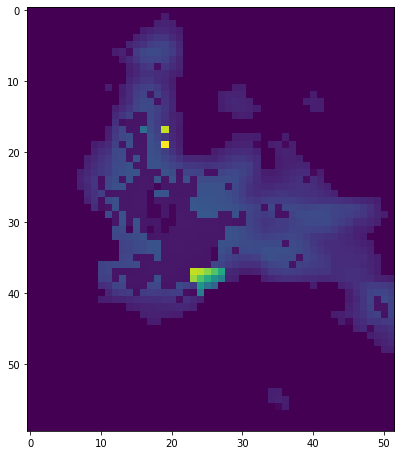

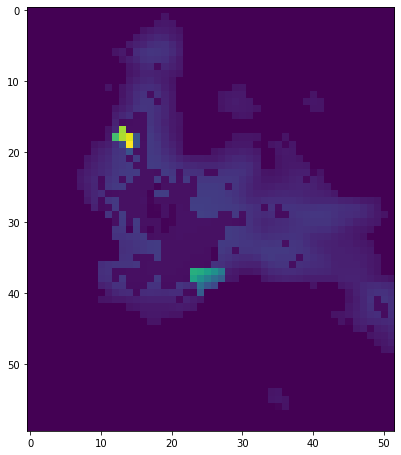

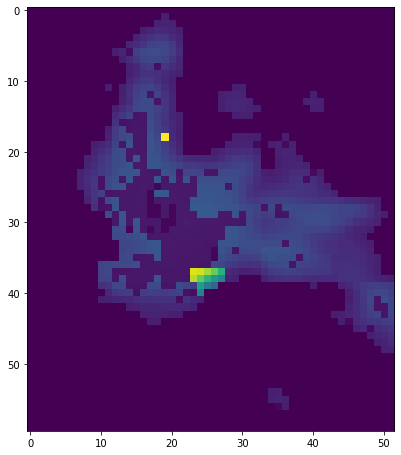

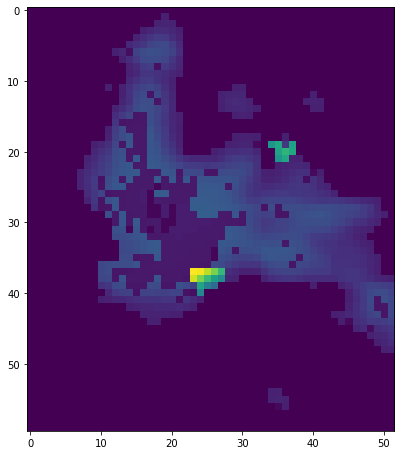

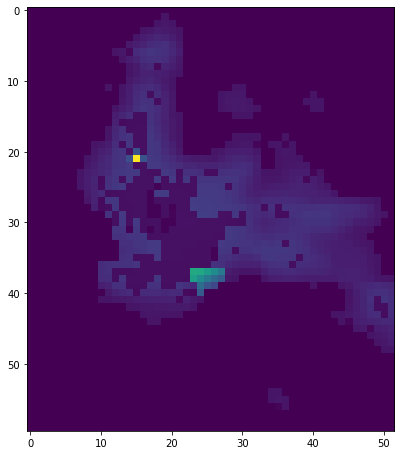

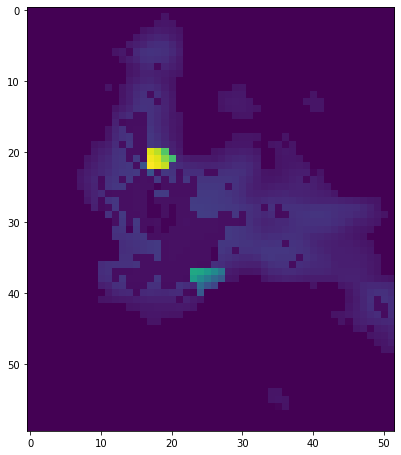

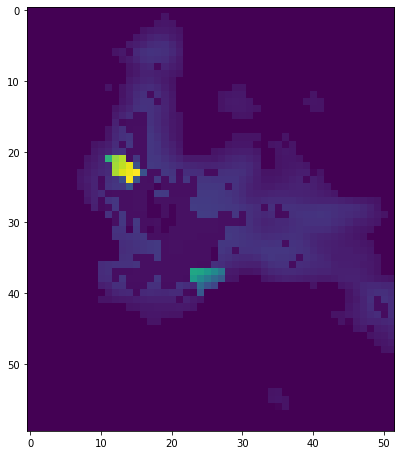

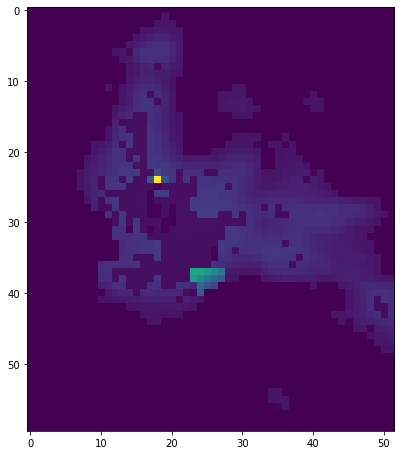

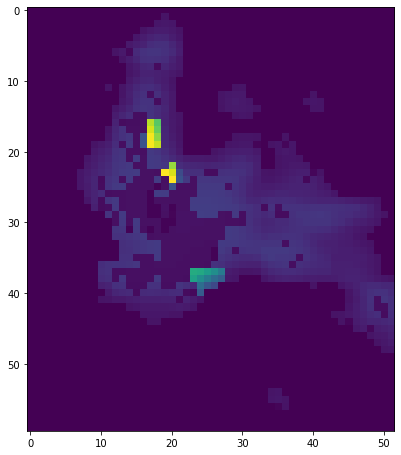

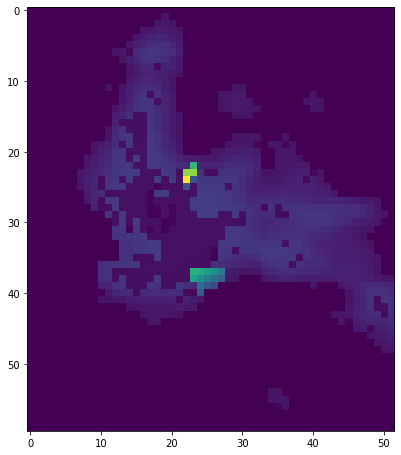

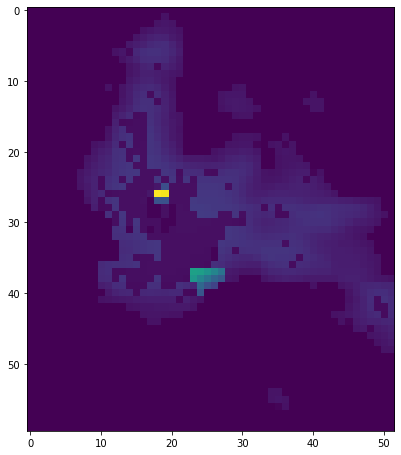

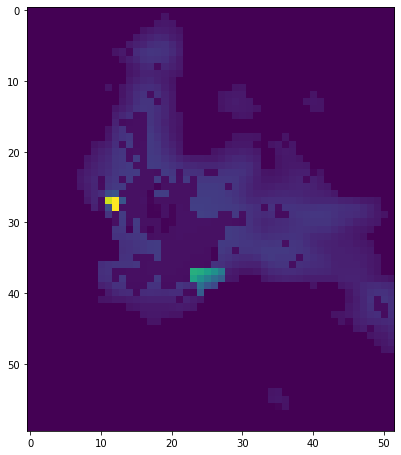

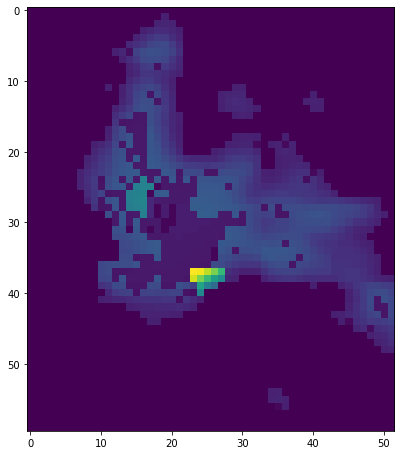

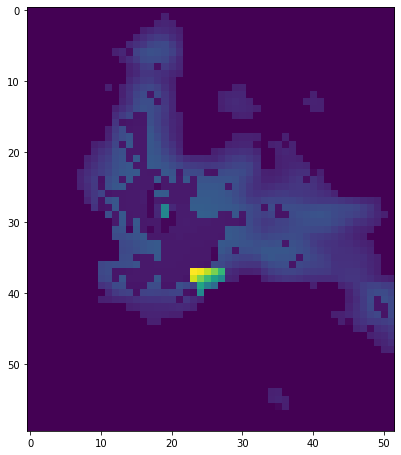

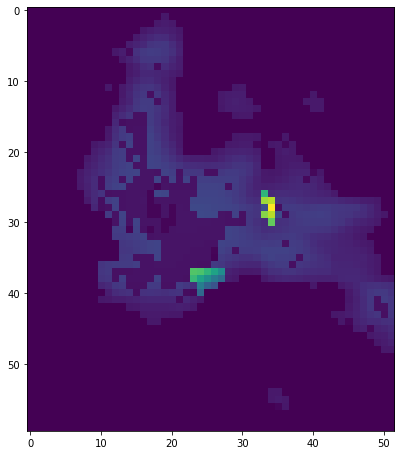

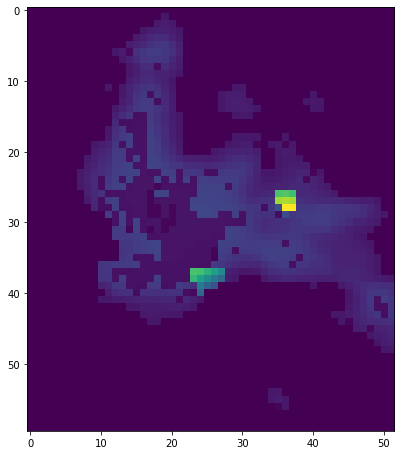

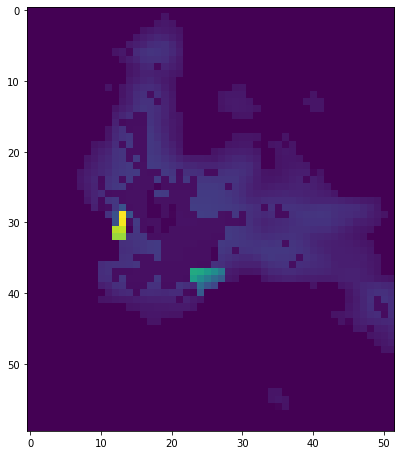

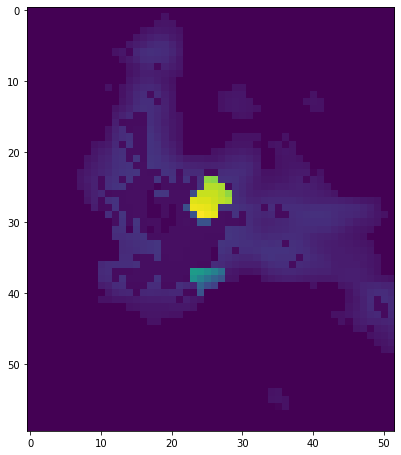

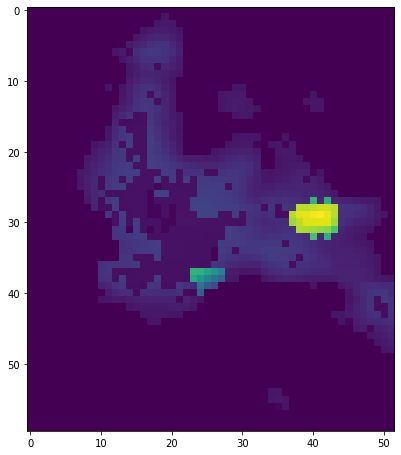

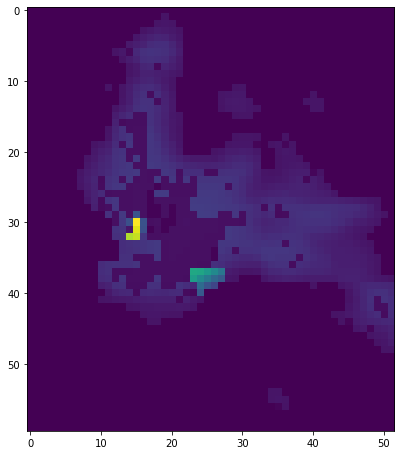

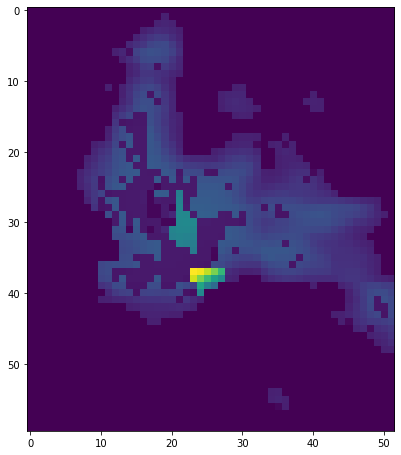

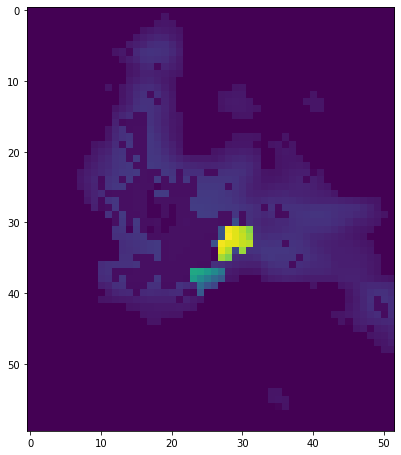

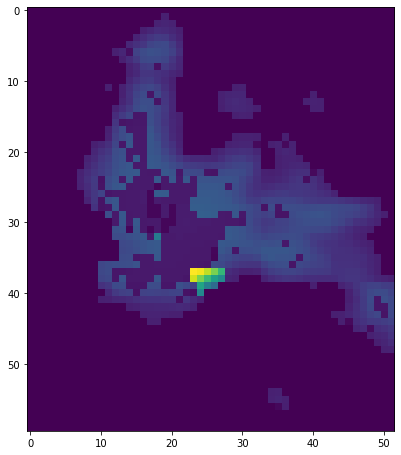

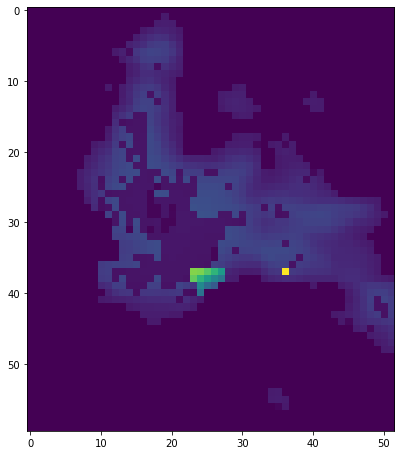

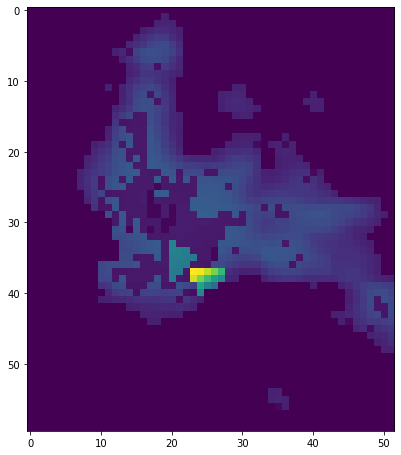

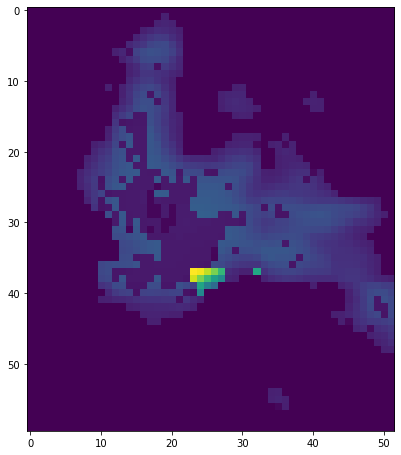

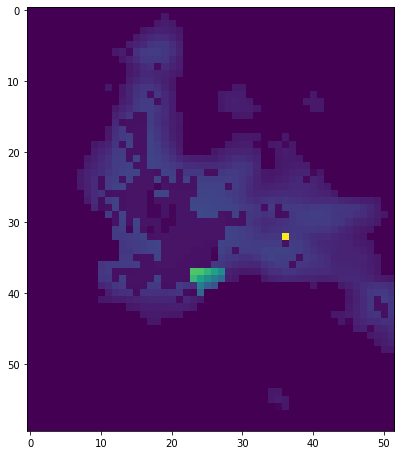

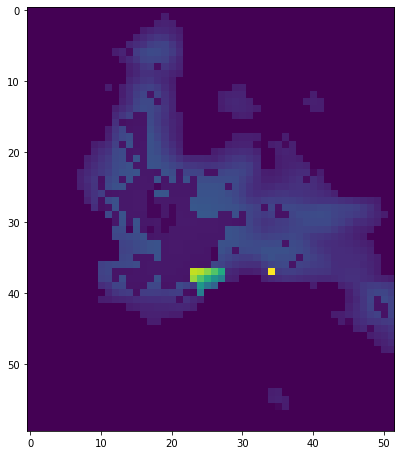

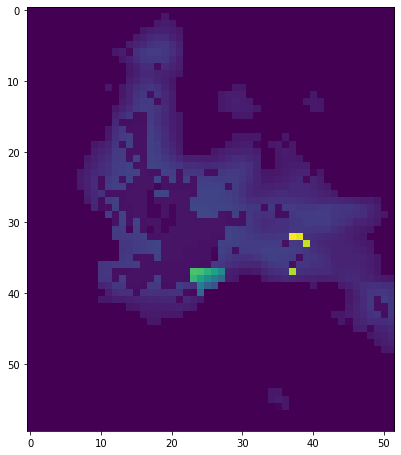

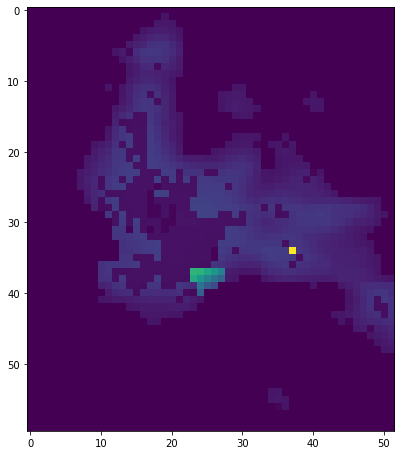

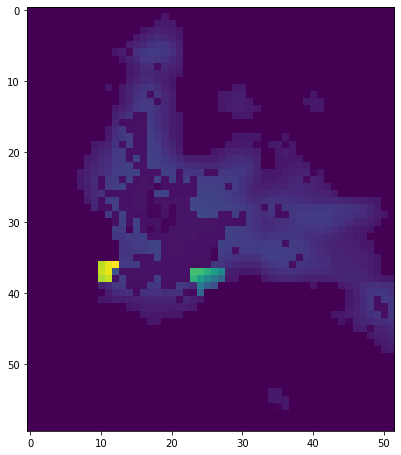

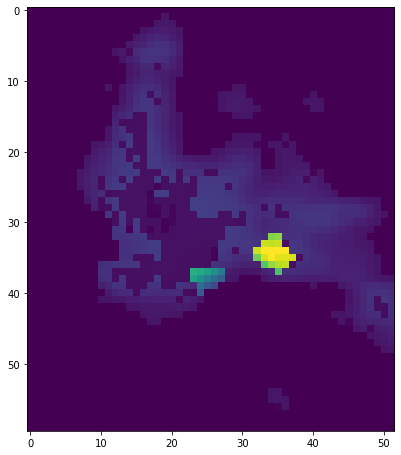

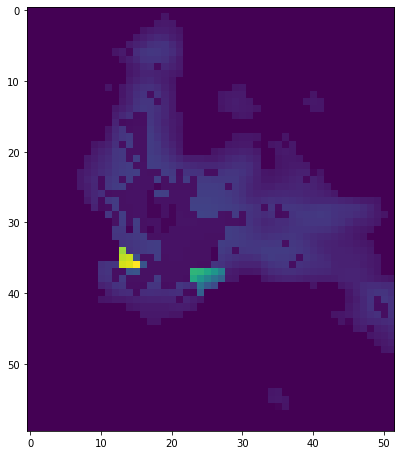

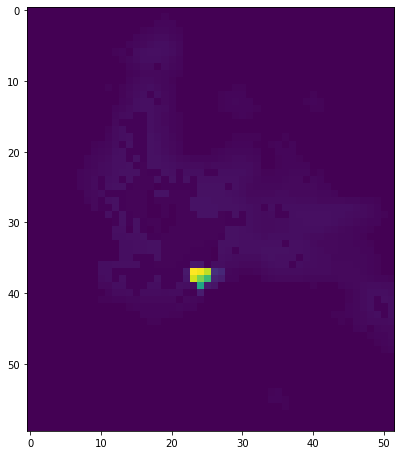

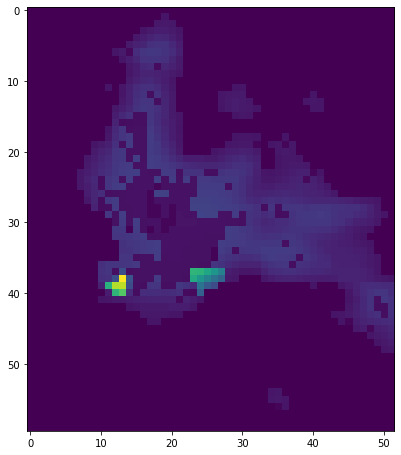

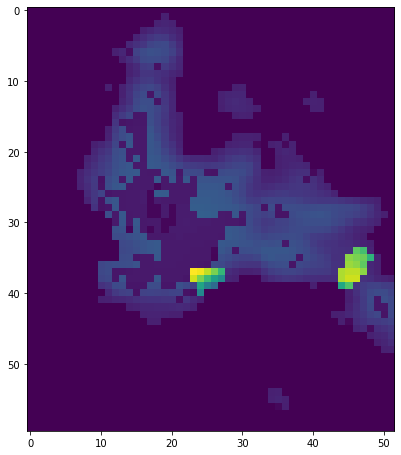

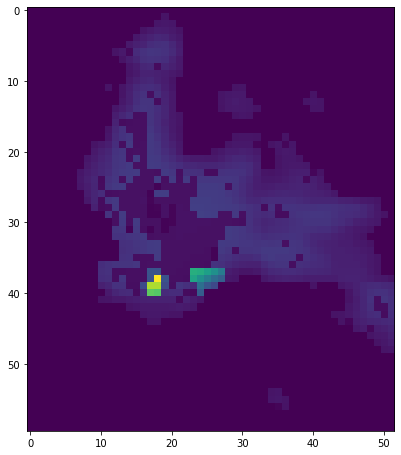

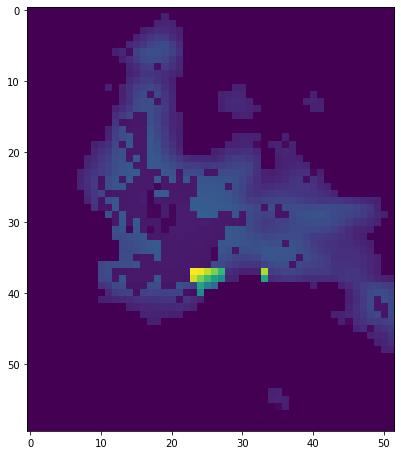

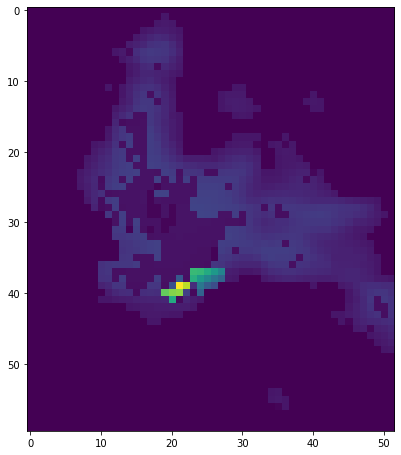

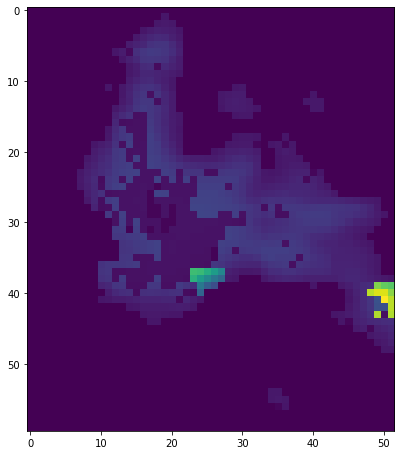

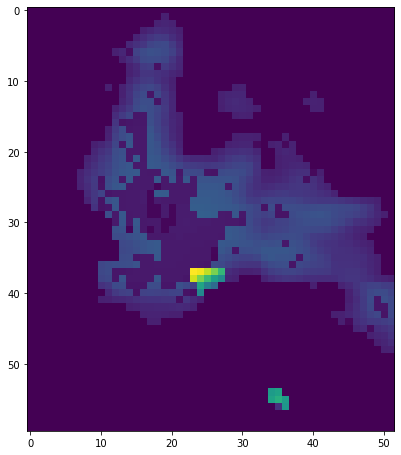

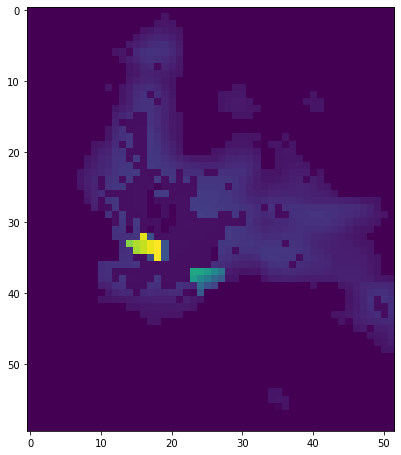

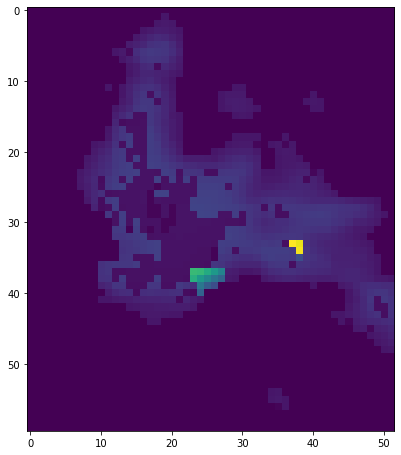

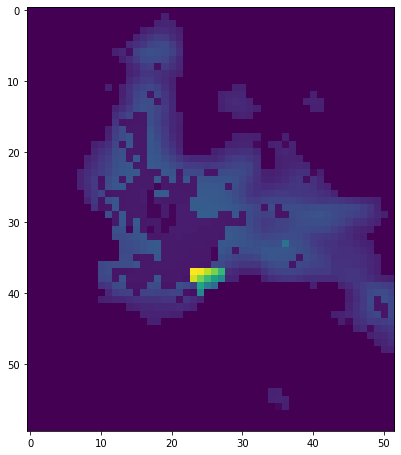

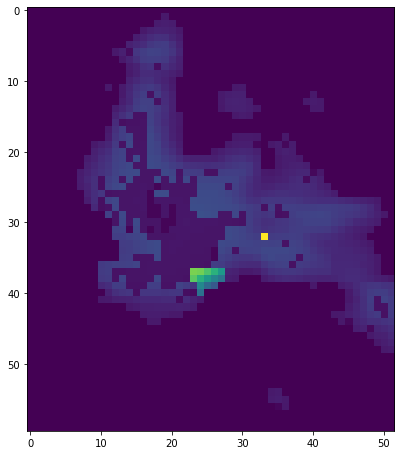

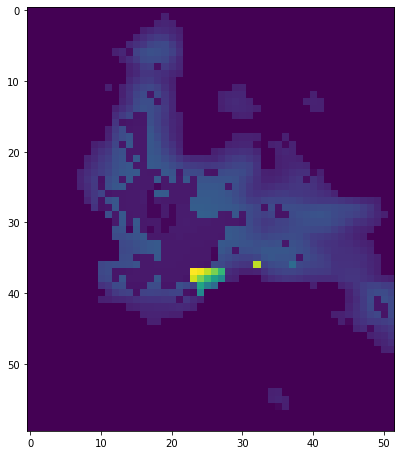

In [24]:
for i in set(allregions.flatten()):
    plt.imshow((allregions==i)*nonsat*5+nonsat)
    plt.show()

In [293]:
a = np.array([0,0,0,1,2,3,4,2,2,3,4,5])

In [298]:

th = 10
out_of_req  = np.where((a<=th)==False)
out_of_req[0][0]


6

array([  18432.        , 1280000.        , 1280000.        ,
       1280000.        , 1280000.        , 1280000.        ,
       1280000.        , 1280000.        , 1280000.        ,
       1280000.        , 1280000.        , 1280000.        ,
       1280000.        , 1280000.        , 1280000.        ,
       1280000.        ,  988553.84615385,  339456.        ,
        204800.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ])

In [121]:
len(coords)

45

a) 7 in the ACM Digital Library; 
b) 206 in IEEE Xplore; 
c) 224 in ScienceDirect;
https://www.sciencedirect.com/search?qs=%28Optimal%20OR%20Optimum%20OR%20Optimization%29%20AND%20Sensor%20AND%20Placement%20AND%20%22Light%20Pollution%22&years=2010%2C2012%2C2013%2C2015%2C2016%2C2017%2C2018%2C2019%2C2020%2C2021%2C2022&lastSelectedFacet=articleTypes&articleTypes=REV%2CFLA
d) 43 in Scopus; 
e) 89 in SpringerLink; and 
f) 16 in Web of Science. 


Optim* AND Sensor AND Placement AND Light AND Pollution